# Определение причин убытков приложения на основе маркетинговых данных

**Цель проекта: выявить причины убытков приложения несмотря на значительные вложения в маркетинг**



Основные этапы исследования:
1. Обработка данных, подготовка их к анализу, выявление пропусков и дубликатов
2. Определение профилей пользователей, анализ дат их привлечения
3. Анализ пользователей по странам - выявление стран с наибольшим количеством платящих пользователей
4. Определение лидирующих устройств, которые предпочитают пользователи
5. Изучение рекламных источников и каналов привлечения пользователей, их анализ
6. Анализ расходов на маркетинг: распределение расходов по источникам, по времени, оценка САС
7. Оценка окупаемости рекламы (LTV, CAC и ROI)
8. Формулирование итоговых выводов

**Исходные данные:**
- visits_info_short.csv - лог сервера с информацией о посещениях сайта
- orders_info_short.csv — информация о заказах
- costs_info_short.csv — информация о расходах на рекламу

**Структура visits_info_short.csv:**<br>
User Id — уникальный идентификатор пользователя,<br>
Region — страна пользователя,<br>
Device — тип устройства пользователя,<br>
Channel — идентификатор источника перехода,<br>
Session Start — дата и время начала сессии,<br>
Session End — дата и время окончания сессии.<br>

**Структура orders_info_short.csv:**<br>
User Id — уникальный идентификатор пользователя,<br>
Event Dt — дата и время покупки,<br>
Revenue — сумма заказа.<br>

**Структура costs_info_short.csv:**<br>
dt — дата проведения рекламной кампании,<br>
Channel — идентификатор рекламного источника,<br>
costs — расходы на эту кампанию<br>

### Обработка данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
#считываем файлы в соответствующие переменные
visits, orders, costs = (pd.read_csv('https://raw.githubusercontent.com/dinomash/marketing_analysis/main/visits_info_short.csv'), 
                         pd.read_csv('https://raw.githubusercontent.com/dinomash/marketing_analysis/main/orders_info_short.csv'),
                         pd.read_csv('https://raw.githubusercontent.com/dinomash/marketing_analysis/main/costs_info_short.csv'))

In [3]:
#проверим типы данных и наличие пропусков в датасете visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
#изменим названия столбцов
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [5]:
#приведем тип данных session_start, session_end к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

#проверим наличие явных дубликатов в данных
visits.duplicated().sum()

0

In [6]:
#проверим наличие неявных дубликатов в данных
for column in visits.columns:
    print(visits[column].unique())

[981449118918 278965908054 590706206550 ... 519022174024 354394066496
 279181973476]
['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
['2019-05-01T02:36:01.000000000' '2019-05-01T04:46:31.000000000'
 '2019-05-01T14:09:25.000000000' ... '2019-10-31T01:40:48.000000000'
 '2019-10-31T07:37:34.000000000' '2019-10-31T14:17:43.000000000']
['2019-05-01T02:45:01.000000000' '2019-05-01T04:47:35.000000000'
 '2019-05-01T15:32:08.000000000' ... '2019-10-31T01:41:31.000000000'
 '2019-10-31T07:37:55.000000000' '2019-10-31T15:17:04.000000000']


Провели замену названий колонок в соответствии со змеиным регистром, изменили необходимые типы данных, проверили наличие дубликатов. Проведем данные операции с оставшимися таблицами.

In [7]:
#проверим типы данных и наличие пропусков в датасете orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
#изменим названия столбцов
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt': 'event_dt', 'Revenue':'revenue'})

#приведем тип данных event_dt к типу datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

#проверим наличие дубликатов в данных
orders.duplicated().sum()

0

In [9]:
#проверим типы данных и наличие пропусков в датасете costs
costs.info()

#изменим названия столбцов
costs.columns = costs.columns.str.lower()

#приведем тип данных dt к типу datetime
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

#проверим наличие явных дубликатов в данных
costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


0

По результатам обработки исходных файлов были изменены типы данных, приведены названия столбцов к "змеиному регистру", а также проведена проверка на наличие дубликатов и пропусков в данных.

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())



    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Составление профилей пользователей

In [18]:
#составление профилей пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [19]:
#выведем общее количество уникальных пользователей
len(profiles)

150008

In [20]:
#определим минимальную дату привлечения пользователей
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [21]:
#определим максимальную дату привлечения пользователей
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

По результатам составления профилей пользователей всего получилось 150 тыс. уникальных пользователей. Самая ранняя дата их привлечения относится к 1 мая 2019 года, самая поздняя к 27 октября 2019 года.

#### Анализ стран пользователей

In [22]:
#составим таблицу пользователей по странам всего и по платящим пользователям из этих стран
profiles_by_country = profiles.groupby('region').agg({'user_id':'nunique'})
profiles_by_country['payers'] = (profiles.query('payer == True')
                                 .groupby('region')
                                 .agg({'user_id':'nunique'}))
profiles_by_country['payers_percent'] = (profiles_by_country['payers']/profiles_by_country['user_id'])*100
profiles_by_country.sort_values(by='user_id', ascending=False)

user_id  payers  payers_percent
region                                        
United States   100002    6902        6.901862
UK               17575     700        3.982930
France           17450     663        3.799427
Germany          14981     616        4.111875

Больше всего пользователей из США - более 100 тыс. (в 5 раз больше остальных стран), также у данной страны наблюдается наиболее высокий процент платящих пользователей 6,9%. В то время как у остальных стран и количество пользователей и процент платящих пользователей примерно одинаковый (4%).

#### Анализ пользователей по используемым устройствам

In [23]:
#составим таблицу пользователей по устройствам всего и по платящим пользователям устройств
profiles_by_device = profiles.groupby('device').agg({'user_id':'nunique'})
profiles_by_device['payers'] = (profiles.query('payer == True')
                                 .groupby('device')
                                 .agg({'user_id':'nunique'}))
profiles_by_device['payers_percent'] = (profiles_by_device['payers']/profiles_by_device['user_id'])*100
profiles_by_device.sort_values(by='user_id', ascending=False)

user_id  payers  payers_percent
device                                  
iPhone     54479    3382        6.207897
Android    35032    2050        5.851793
PC         30455    1537        5.046790
Mac        30042    1912        6.364423

Наибольшее количество пользователей предпочитают продукцию компании Apple: всего 84 521 человек. Также среди данных пользователей наибольший процент платящих пользователей более 6,2% в зависимости от устройства. Лидером же по устройствам в целом по количеству пользователей является IPhone (54 тыс.). 

#### Анализ по каналам привлечения

In [24]:
#составим таблицу пользователей по каналам привлечения и по платящим пользователям с данных каналов
profiles_by_channel = profiles.groupby('channel').agg({'user_id':'nunique'})
profiles_by_channel['payers'] = (profiles.query('payer == True')
                                 .groupby('channel')
                                 .agg({'user_id':'nunique'}))
profiles_by_channel['payers_percent'] = (profiles_by_channel['payers']/profiles_by_channel['user_id'])*100
profiles_by_channel.sort_values(by='payers_percent', ascending=False)

user_id  payers  payers_percent
channel                                            
FaceBoom              29144    3557       12.204914
AdNonSense             3880     440       11.340206
lambdaMediaAds         2149     225       10.469986
TipTop                19561    1878        9.600736
RocketSuperAds         4448     352        7.913669
WahooNetBanner         8553     453        5.296387
YRabbit                4312     165        3.826531
MediaTornado           4364     156        3.574702
LeapBob                8553     262        3.063253
OppleCreativeMedia     8605     233        2.707728
organic               56439    1160        2.055316

Интересно отметить, что наибольшее количество пользователей привлечено с помощью органического трафика. При этом, доля плательщиков среди них самая низкая 2.05%. Наиболее интересным каналом привлечения является FaceBoom - при том, что количество пользователей, привлеченных по данному каналу практически в два раза меньше, чем от органического трафика, количество плательщиков же в натуральном выражении в два раза больше - 3,5 тыс. человек. Процент платящих пользователей составляет 12,20%, что является наиболее высоким показателям по всем источникам. Также стоит обратить внимание на каналы с высокими показателями процентов плательщиков пользователей (9-11%) - TipTop, AdNonSense, lambdaMediaAds.

Наиболее неэффективными каналами (процент платящих пользователей ниже 4%) можно назвать: OppleCreativeMedia, LeapBob, MediaTornado, YRabbit.

### Анализ затрат на маркетинг

#### Распределение затрат по рекламным источникам

In [25]:
#подсчитаем общую сумму расходов на маркетинг
total_costs = costs['costs'].sum()
total_costs

105497.30000000002

In [26]:
#посмотрим расходы по каждому источнику
costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_by_channel['percent_from_total'] = ((costs_by_channel['costs']/total_costs)*100).round(2)
costs_by_channel

costs  percent_from_total
channel                                         
TipTop              54751.30               51.90
FaceBoom            32445.60               30.75
WahooNetBanner       5151.00                4.88
AdNonSense           3911.25                3.71
OppleCreativeMedia   2151.25                2.04
RocketSuperAds       1833.00                1.74
LeapBob              1797.60                1.70
lambdaMediaAds       1557.60                1.48
MediaTornado          954.48                0.90
YRabbit               944.22                0.90

Общий рекламный бюджет составил 105 497. Наибольшая доля бюджета (более 50%) приходится на источник TipTop (51,9 тыс.) Также более 30% относится к источнику FaceBoom (затраты 32 тыс.). Использование данных источников оправдано - именно по ним наблюдается наибольшее количество пользователей (не считая органического трафика), а также одни из наиболее высоких процентов платящих пользователей. Доля затрат по остальным каналам незначительная - менее 5%.

Предварительно можно сказать, что в будущем стоит обратить внимание на такие каналы продвижения как AdNonSense и lambdaMediaAds (по ним незначительные бюджеты, при этом процент платящих пользователей относительно высокий). 

#### Динамика изменения затрат на рекламу

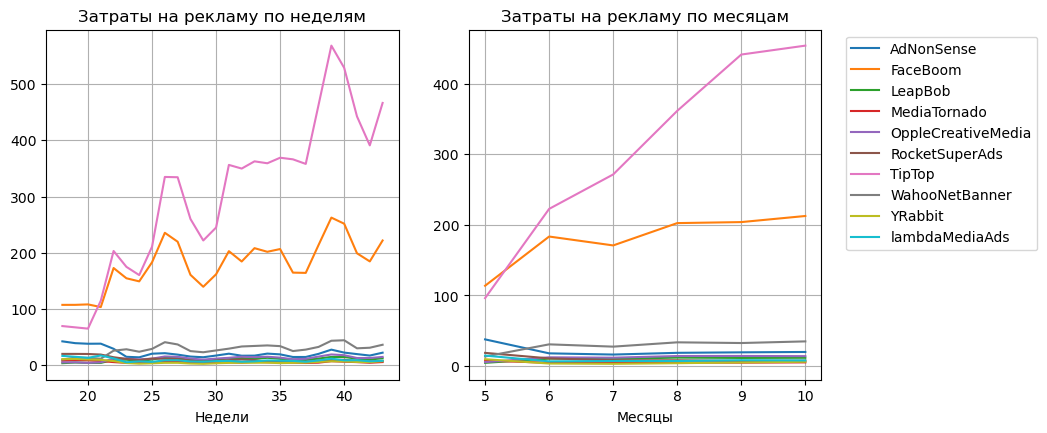

In [27]:
#добавим столбец с номером недели и номером месяца
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
#построим графики изменения затрат по источникам
#затраты по неделям
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(2, 2, 1)
costs.pivot_table(index='week', columns='channel', values='costs').plot(grid=True, ax=ax1, legend=None)
plt.xlabel('Недели')
plt.title('Затраты на рекламу по неделям')
ax2 = plt.subplot(2, 2, 2)
#затраты по месяцам
costs.pivot_table(index='month', columns='channel', values='costs').plot(grid=True, ax=ax2)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Месяцы')
plt.title('Затраты на рекламу по месяцам')
plt.show()


Особенно на графиках выделяются два источника рекламы - TipTop и FaceBoom. При этом, если у FaceBoom динамика была в целом одинаковая на протяжении всего года (стабильный небольшой рост на протяжении всего года), то у TipTop зафиксировано значительное увеличение затрат начиная примерно с 38 недели. 


#### Расчет среднего САС по пользователям 

In [28]:
#расчитаем средний САС по каналам привлечения
profiles_by_channel['cac'] = costs_by_channel['costs']/profiles_by_channel['user_id']
profiles_by_channel.sort_values(by='cac', ascending=False)

user_id  payers  payers_percent       cac
channel                                                      
TipTop                19561    1878        9.600736  2.799003
FaceBoom              29144    3557       12.204914  1.113286
AdNonSense             3880     440       11.340206  1.008054
lambdaMediaAds         2149     225       10.469986  0.724802
WahooNetBanner         8553     453        5.296387  0.602245
RocketSuperAds         4448     352        7.913669  0.412095
OppleCreativeMedia     8605     233        2.707728  0.250000
YRabbit                4312     165        3.826531  0.218975
MediaTornado           4364     156        3.574702  0.218717
LeapBob                8553     262        3.063253  0.210172
organic               56439    1160        2.055316       NaN

In [29]:
#расчитаем средний САС для одного пользователя
profiles['acquisition_cost'].mean()

0.7032778251827625

Наиболее дорогим источником привлечения клиентов оказался TipTop - средняя стоимость за одного пользователя 2,8. При этом процент платящих пользователей из данного источника не самый высокий. Источники, имеющие бОльший процент платящих пользователей при этом более чем в два раза дешевле FaceBoom - 1,11 и AdNonSense - 1. Органический трафик является бесплатным - следовательно САС по нему отсутствует.

### Оценка окупаемости рекламы

#### Общий анализ окупаемости рекламы 

Текущая дата для анализа 1 ноября 2019 года. Согласно запросу от заказчика пользователи должны окупаться не позднее чем через две недели после привлечения. Также для целей анализа исключим органических пользователей из данных.

In [30]:
#удаляем пользователей из органического трафика из данных
profiles = profiles.query('channel != "organic"')

In [31]:
#установим момент анализа и горизонт для анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14

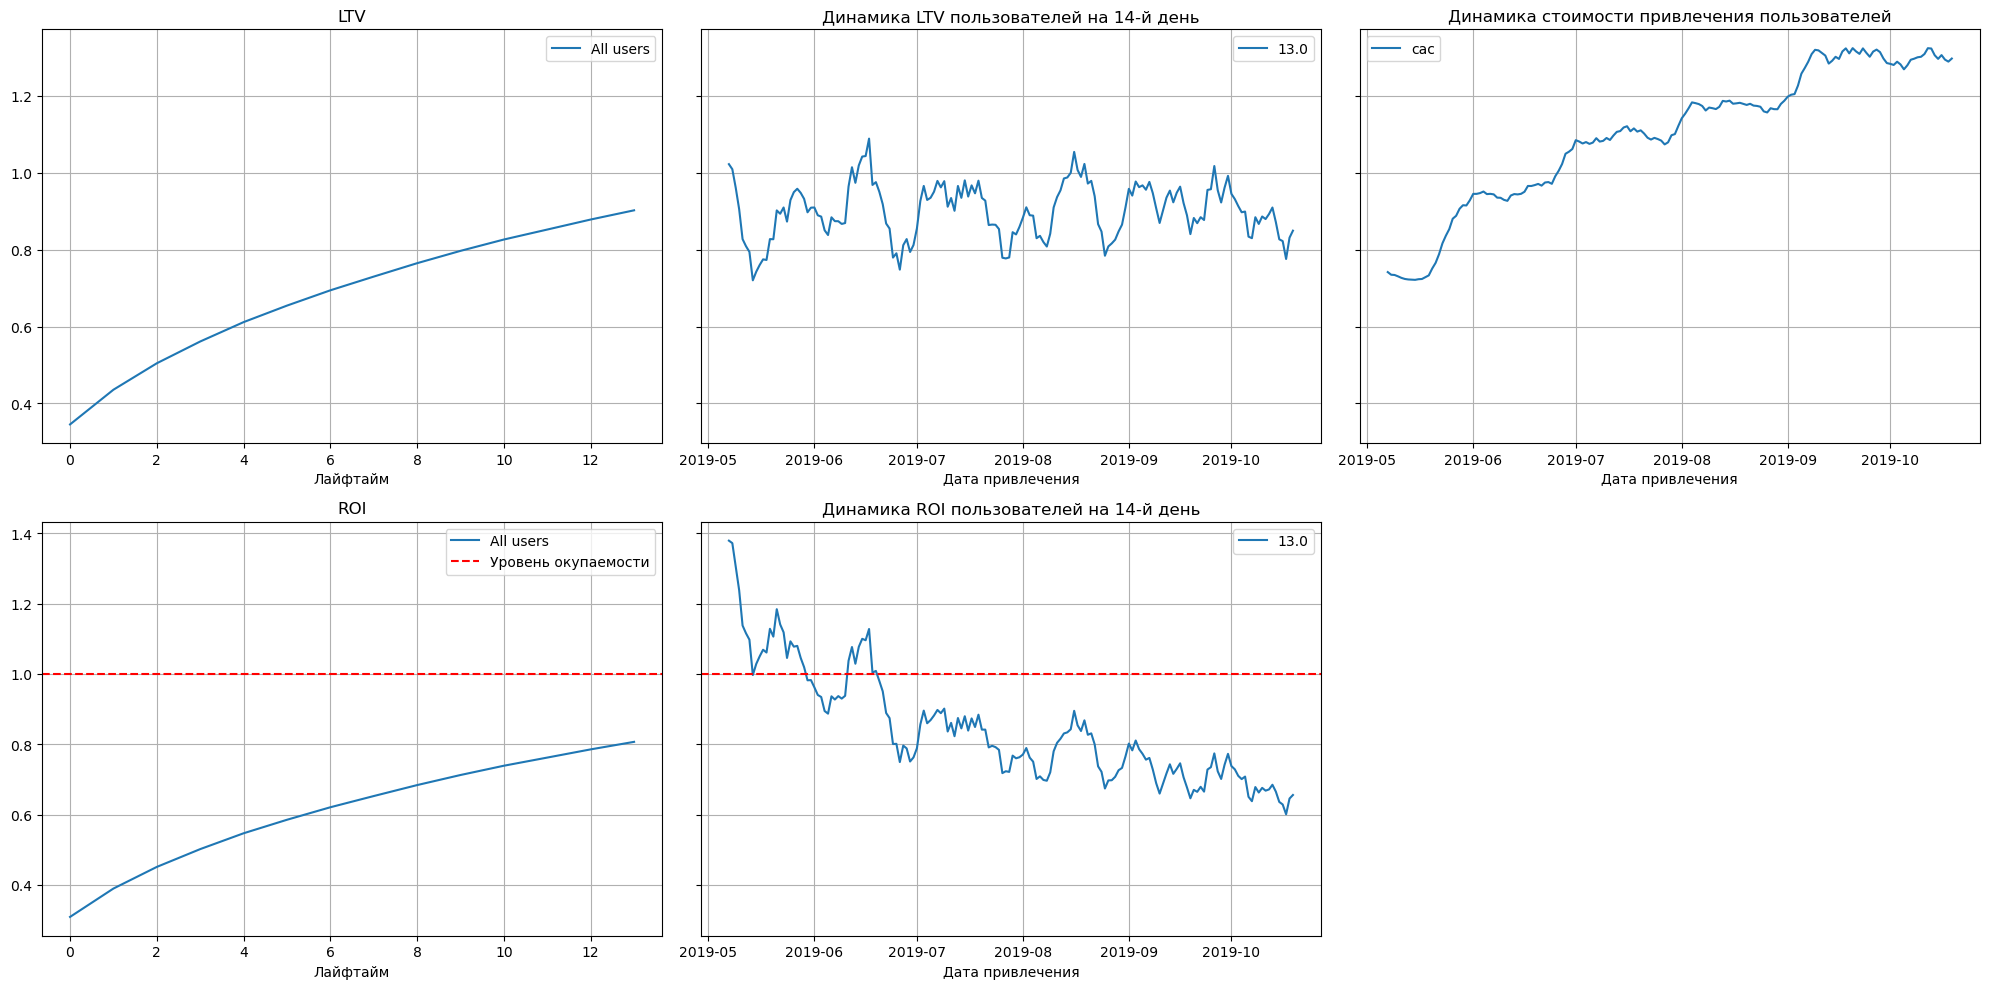

In [32]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы по графикам:**
- LTV растет, следовательно момент и горизонт данных определен корректно
- на 14й день общий ROI значительно ниже уровня окупаемости
- динамика САС увеличивается - следовательно растут рекламные бюджеты
- динамика ROI пользователей снижается: ниже уровня окупаемости находятся пользователи, привлеченные после 7 октября, стоимость привлечения при этом растет

#### Анализ конверсии и удержания пользователей

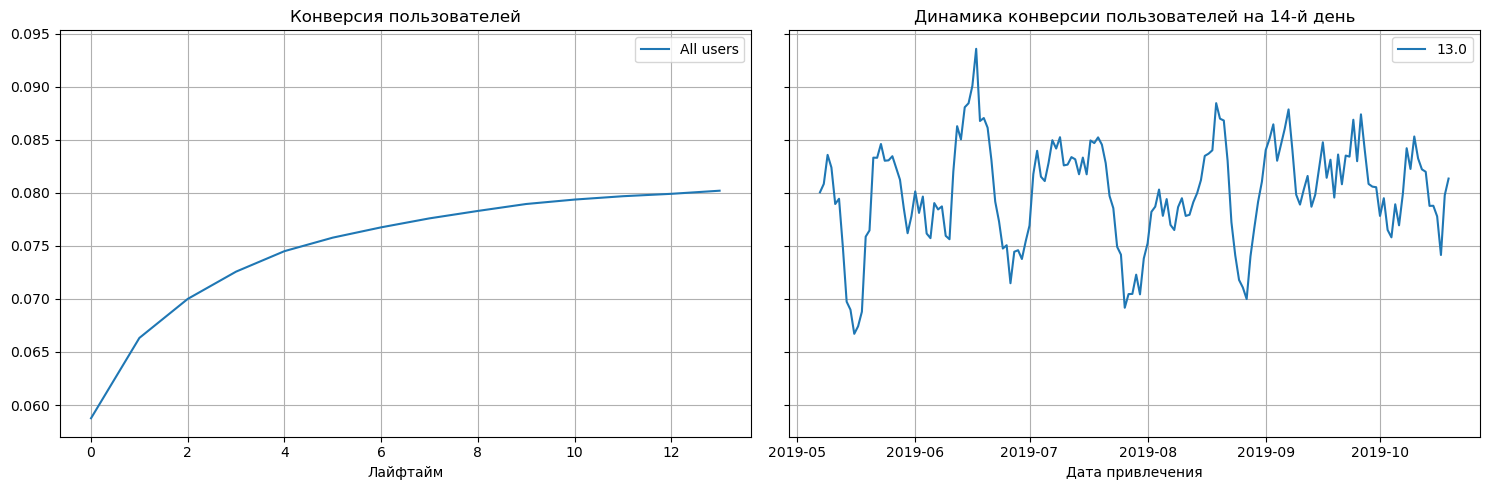

In [33]:
# посмотрим общую конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей растет и динамика в целом положительная. Построим графики удержания.

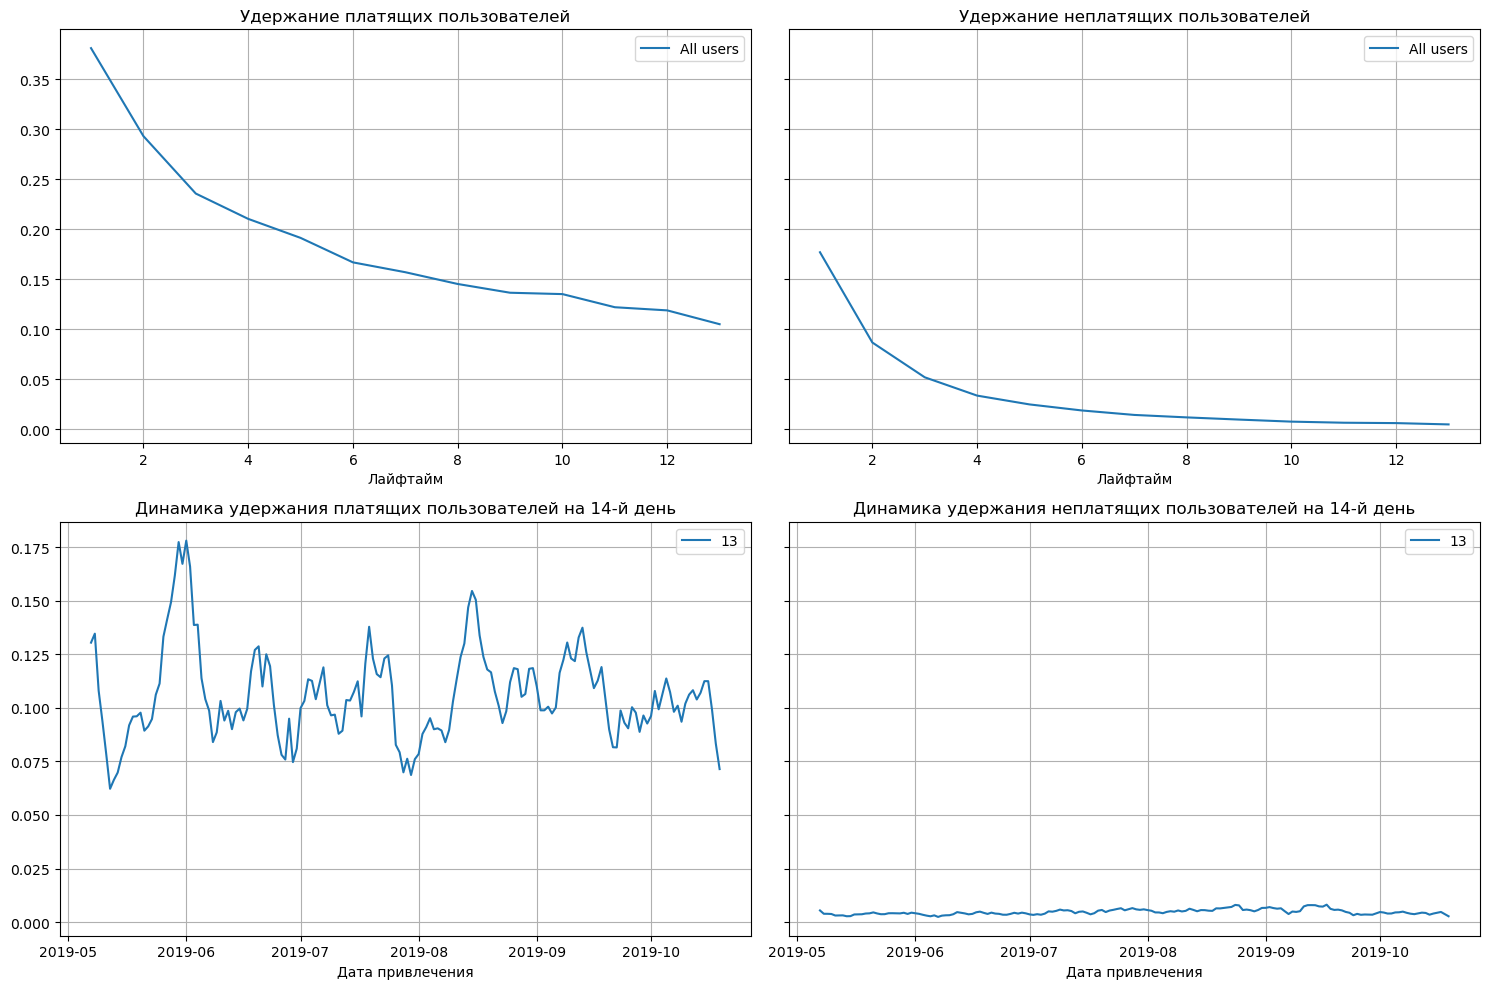

In [34]:
# посмотрим общее удержание пользователей

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих и неплатящих пользователей значительно снижается к 14 дню. В дальнейшем анализе посмотрим на возможные причины данного явления. 

#### Анализ окупаемости рекламы в зависимости от устройств

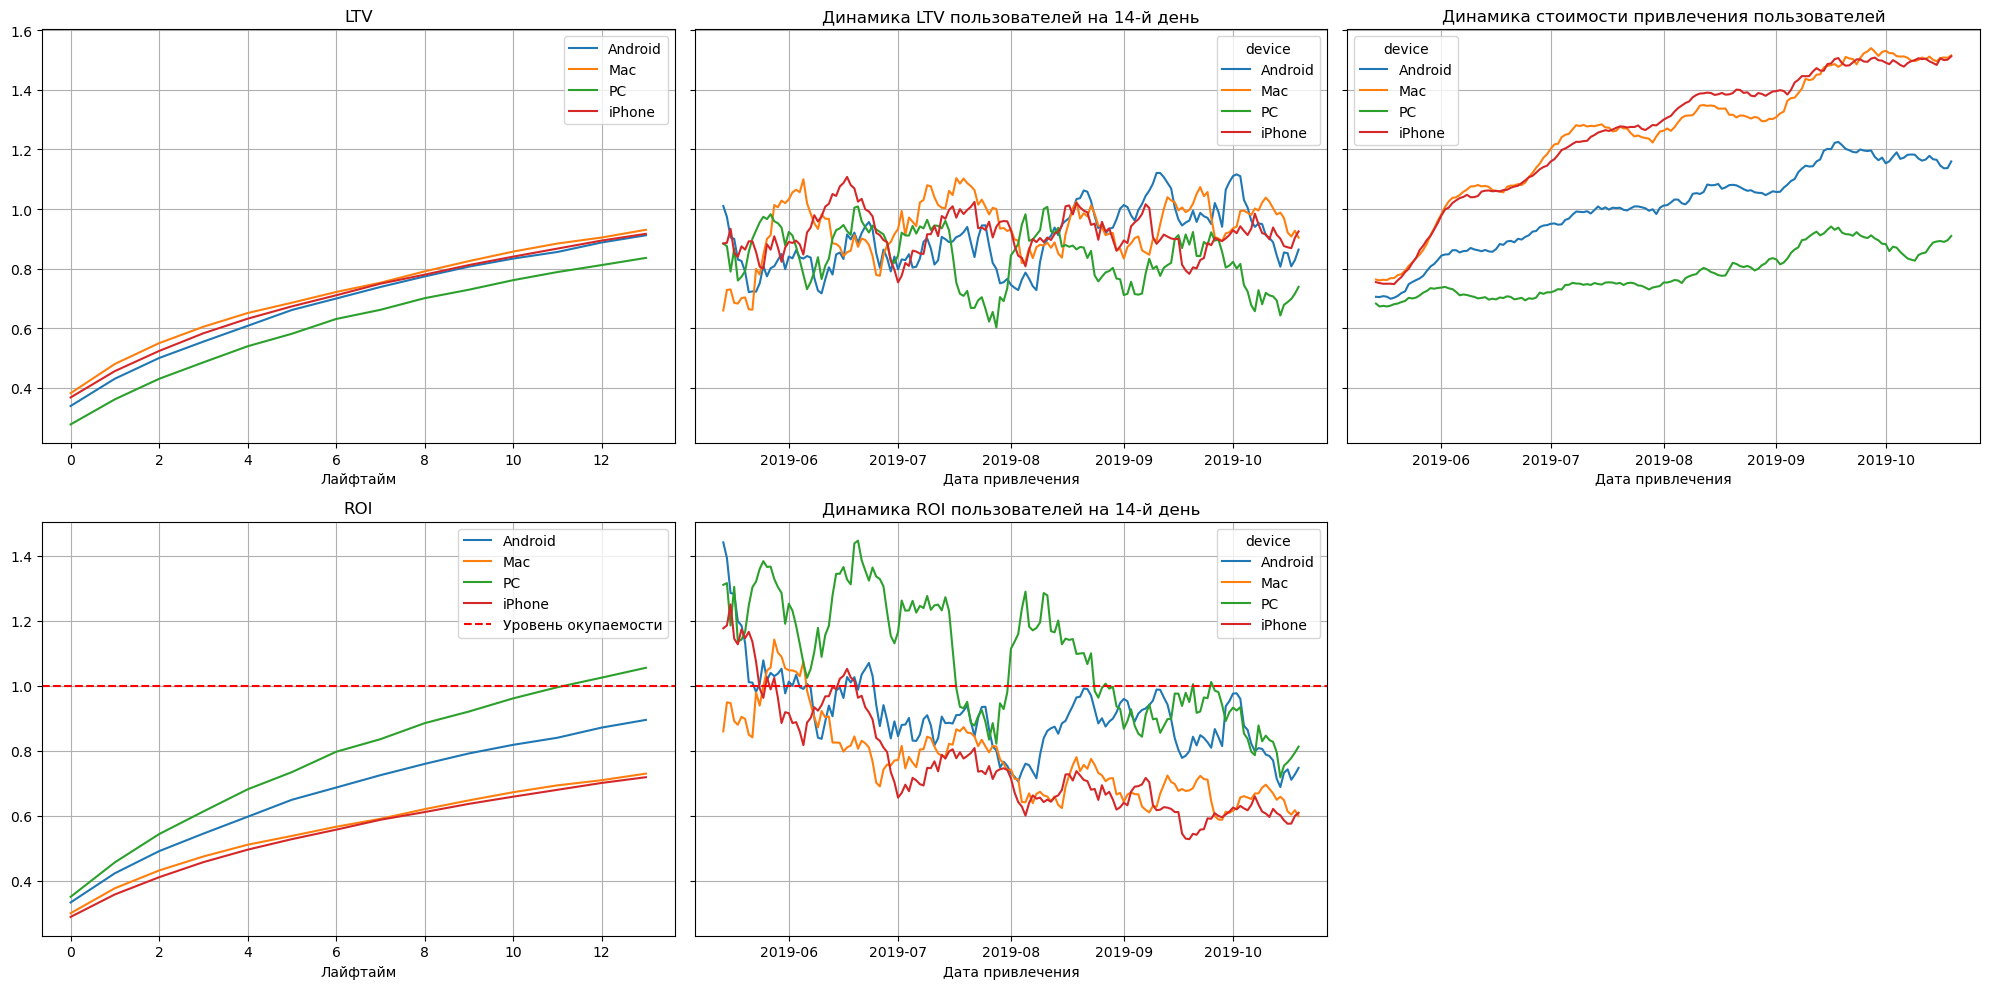

In [35]:
# считаем LTV и ROI, строим графики
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

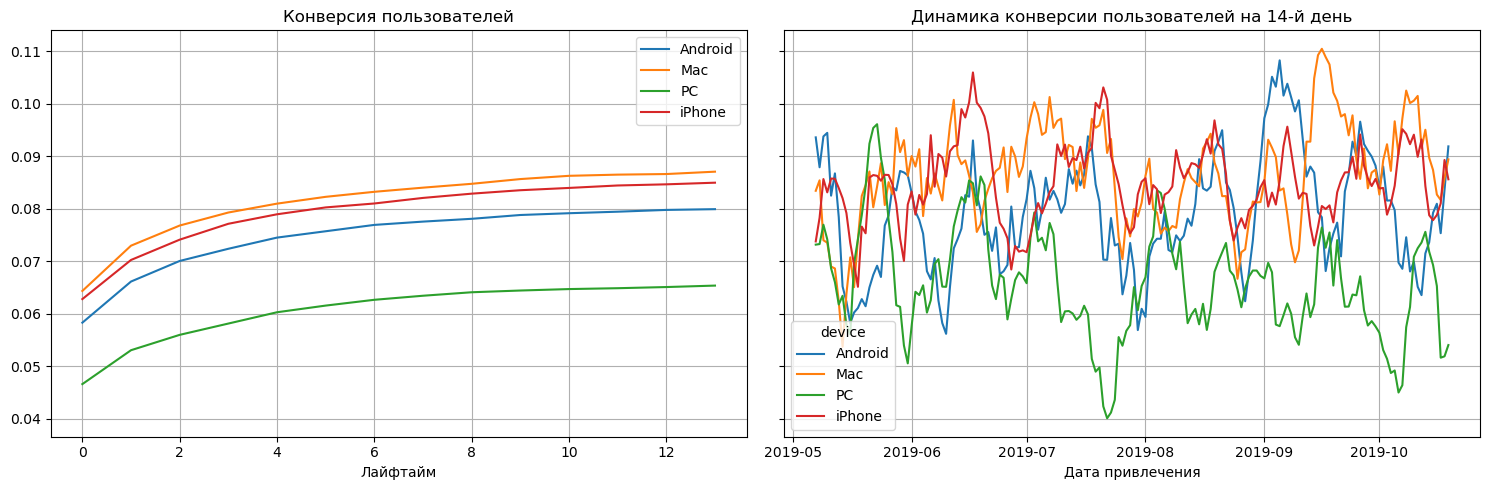

In [36]:
# посмотрим конверсию по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

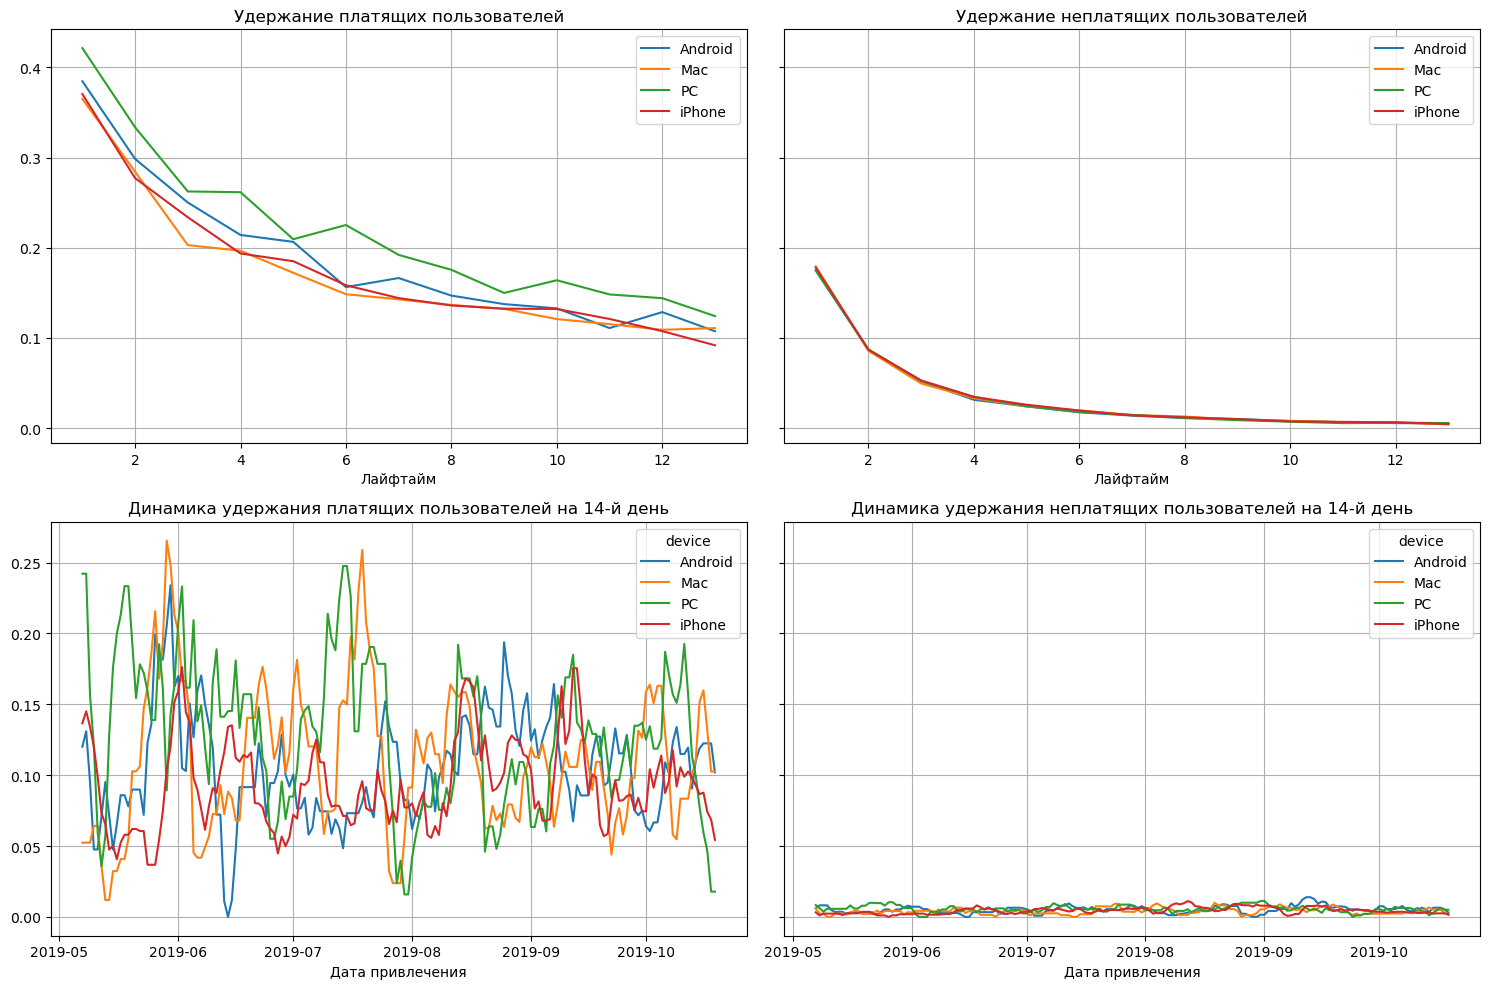

In [37]:
# посмотрим удержание пользователей по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы по устройствам:**
- LTV по всем устройствам (за исключение РС) является примерно одинаковым
- общая стоимость привлечения по всем устройствам постоянно увеличивается, при этом стоимость привлечения пользователей на устройствах компании Apple (MAC и IPhone) начиная с июня значительно выше стоимости по другим устройствам
- по всем устройствам кроме РС не достигается безубыточный уровень на 14 день, при этом у РС самые низкие показатели конверсии
- несмотря на высокую стоимость привлечения, показатели удержания платящих пользователей Apple самые низкие среди всех

#### Анализ окупаемости рекламы по странам

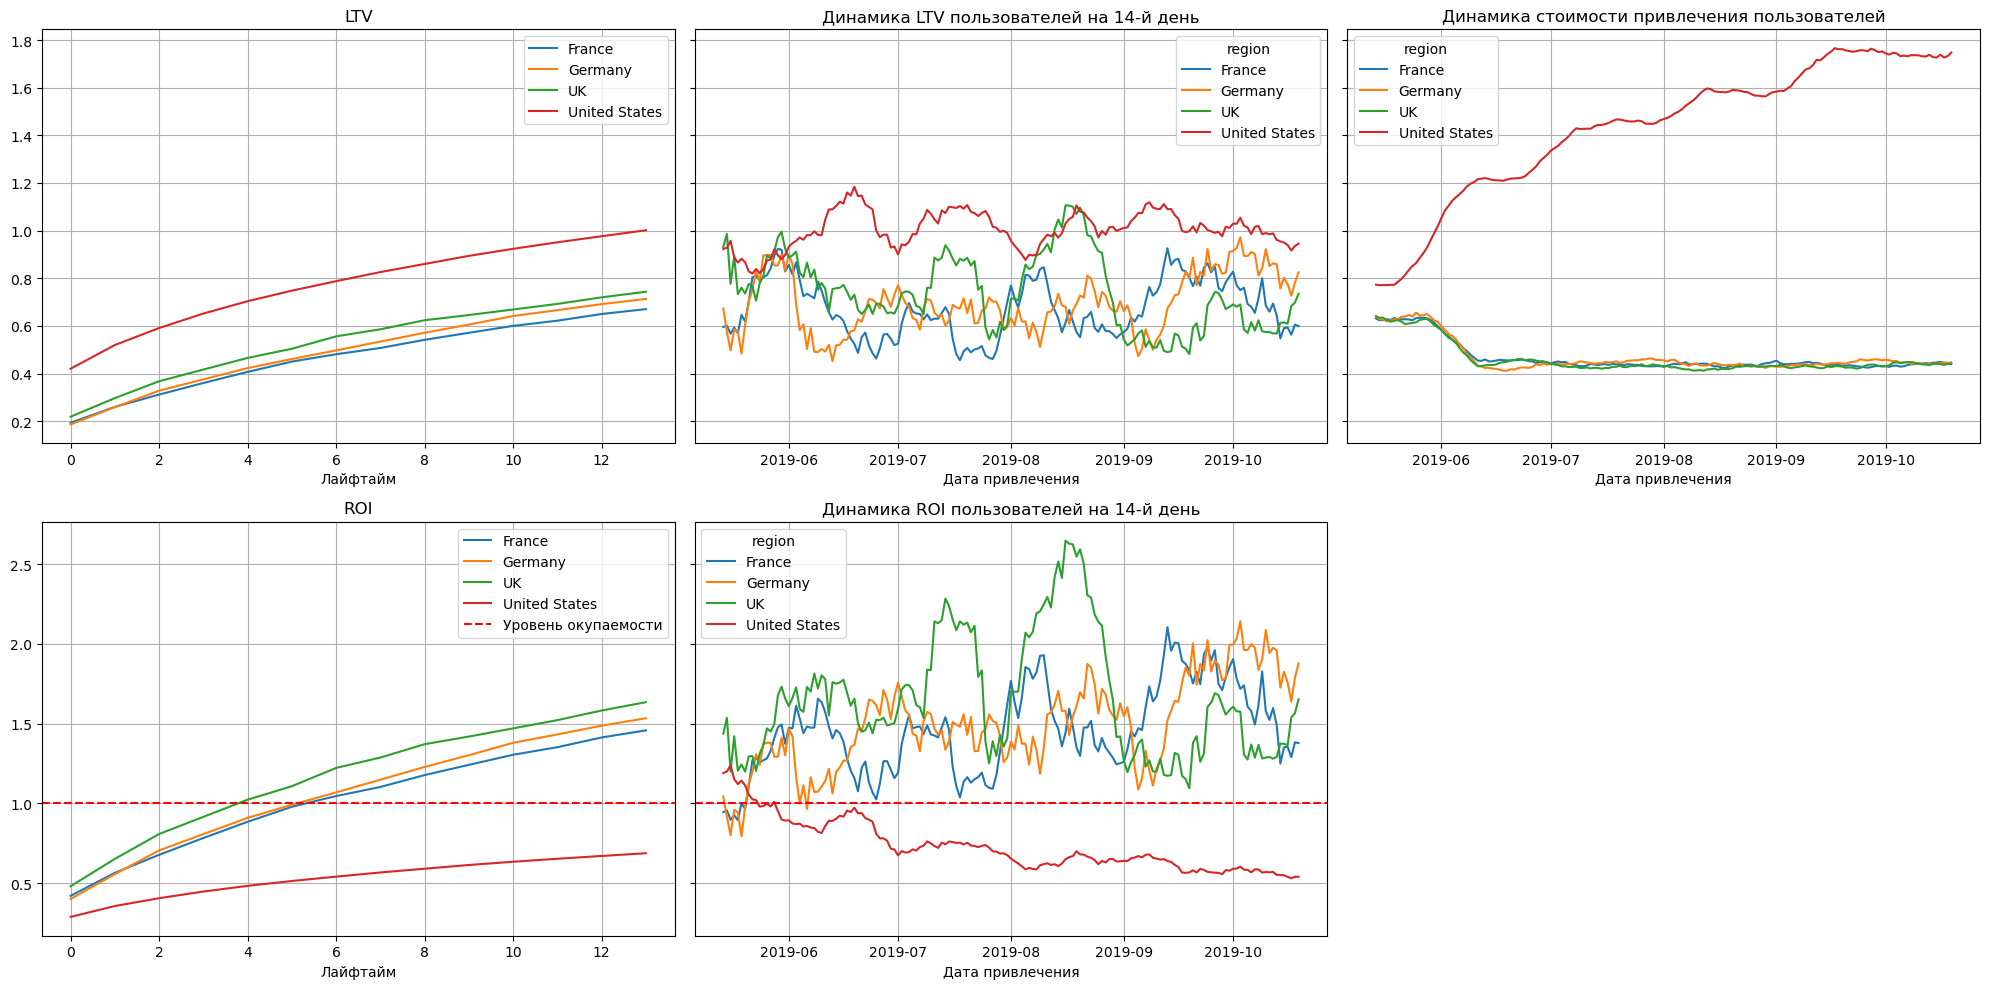

In [38]:
# считаем LTV и ROI, строим графики
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

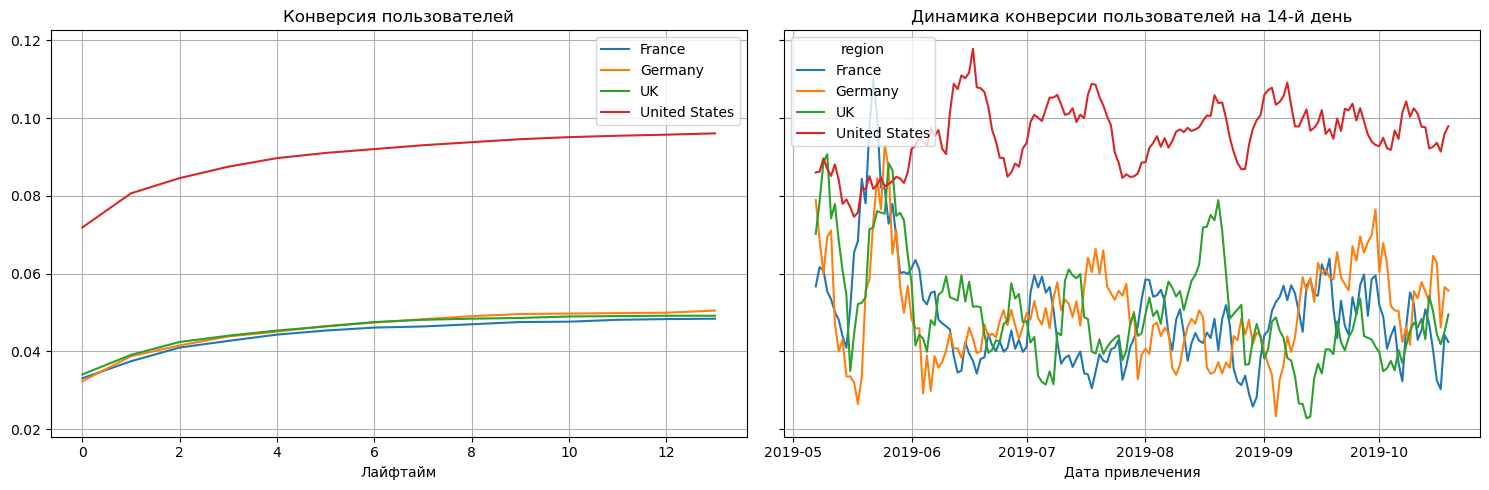

In [39]:
# посмотрим конверсию по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

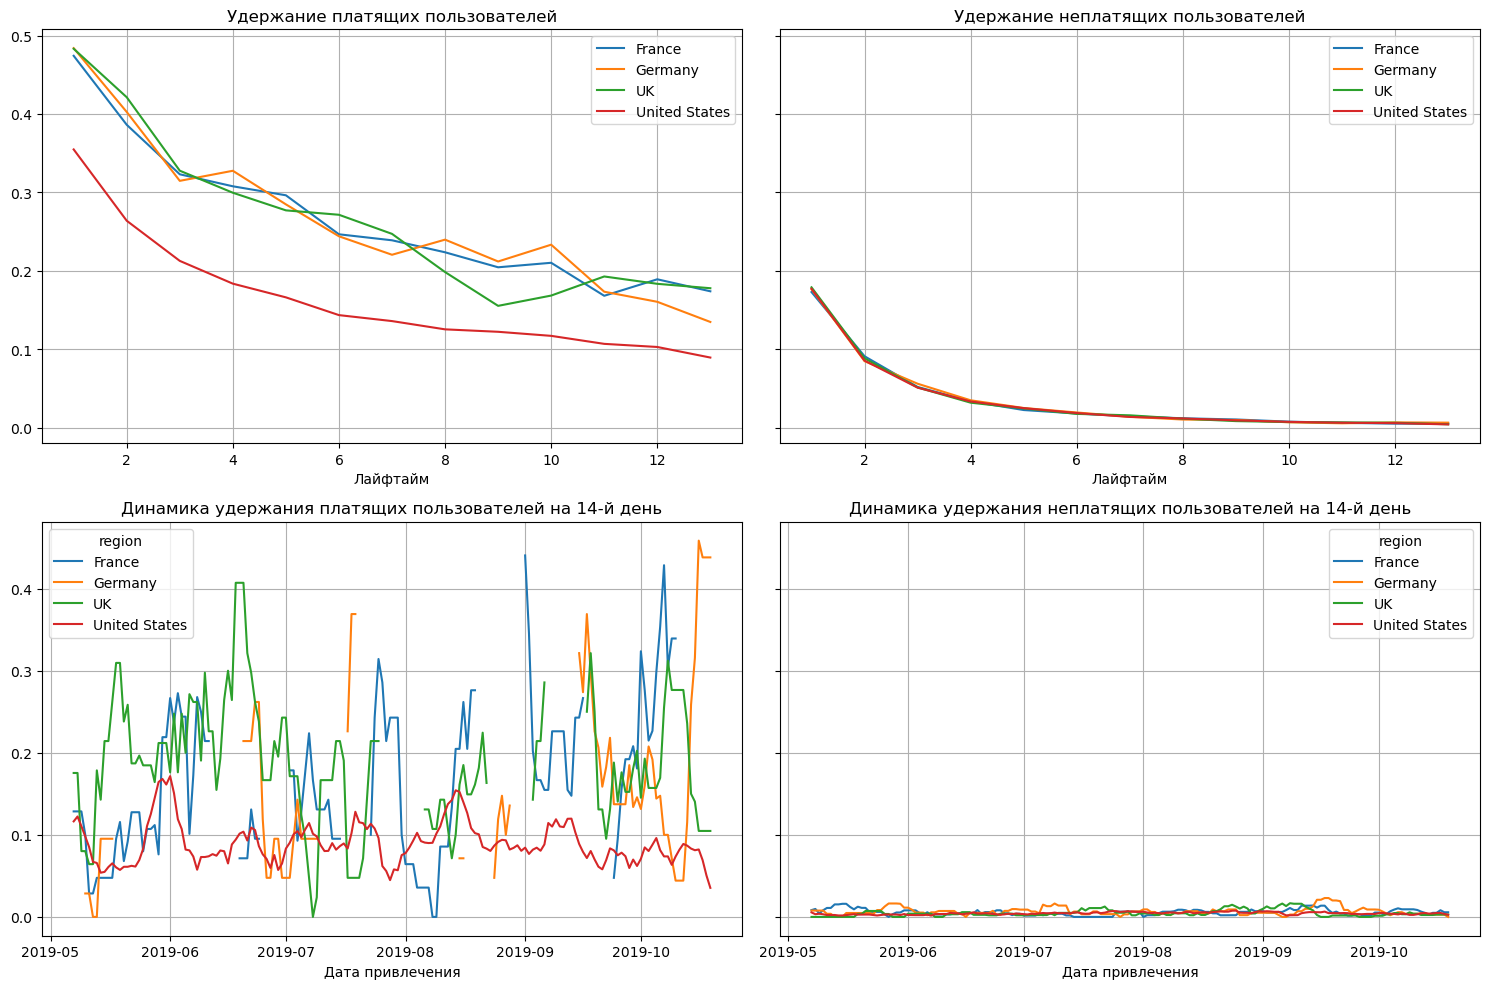

In [40]:
# посмотрим удержание пользователей по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы по странам:**
В ходе анализа по странам выявлено, что США оказывает то негативное влияние на текущую ситуацию - отсутствие окупаемости на 14й день, высокие затраты на привлечение новых пользователей. Несмотря на то, что LTV для США является наиболее высоким, за счет высокой стоимости рекламной кампании в данной стране уровень окупаемости не достигнут на 14й день. При этом в большинстве стран уровень окупаемости достигается уже на 5й день. Скорее всего именно в июне было принято решение о значительных вложениях в рынок США, но инструменты были выбраны не очень эффективные и не соизмеримые с возможностями компании. Также у США несмотря на высокий уровень конверсии, показатель удержания пользователей самый низкий среди всех стран. 

#### Анализ окупаемости рекламы по каналам привлечения пользователей

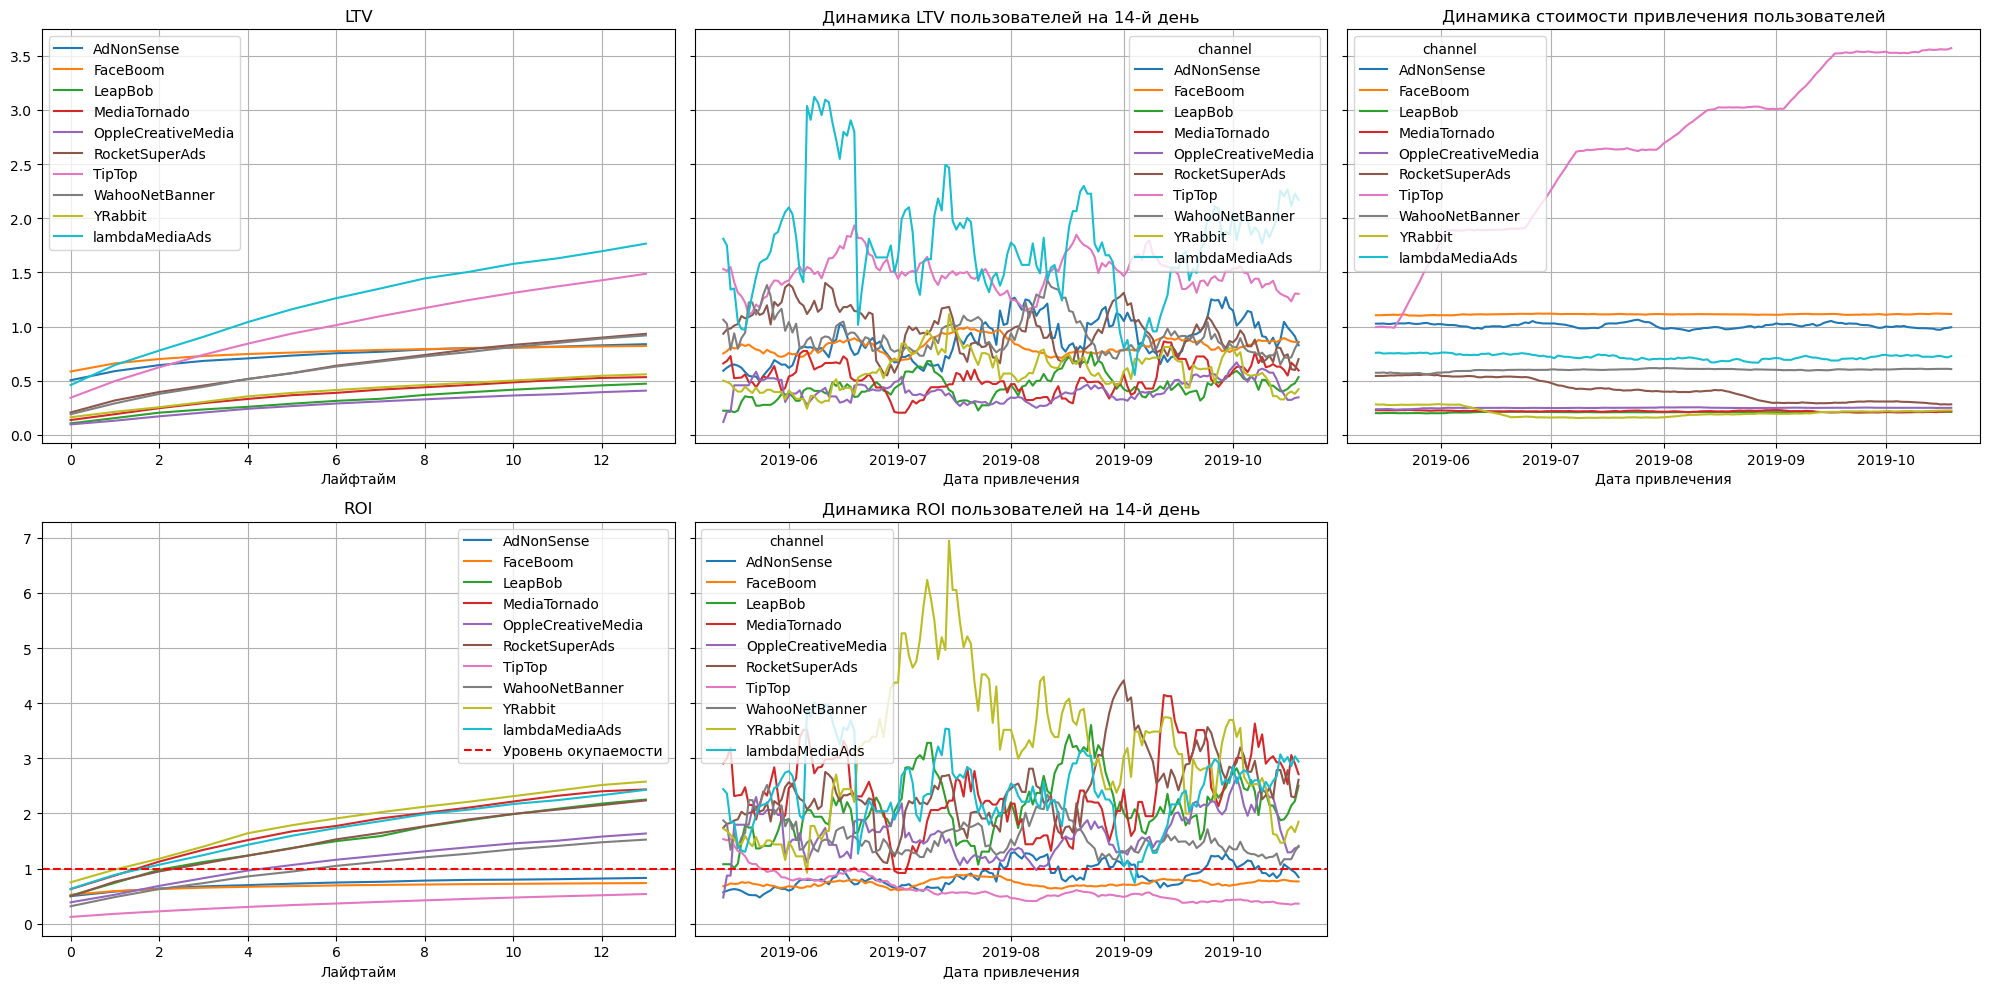

In [41]:
# считаем LTV и ROI, строим графики
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

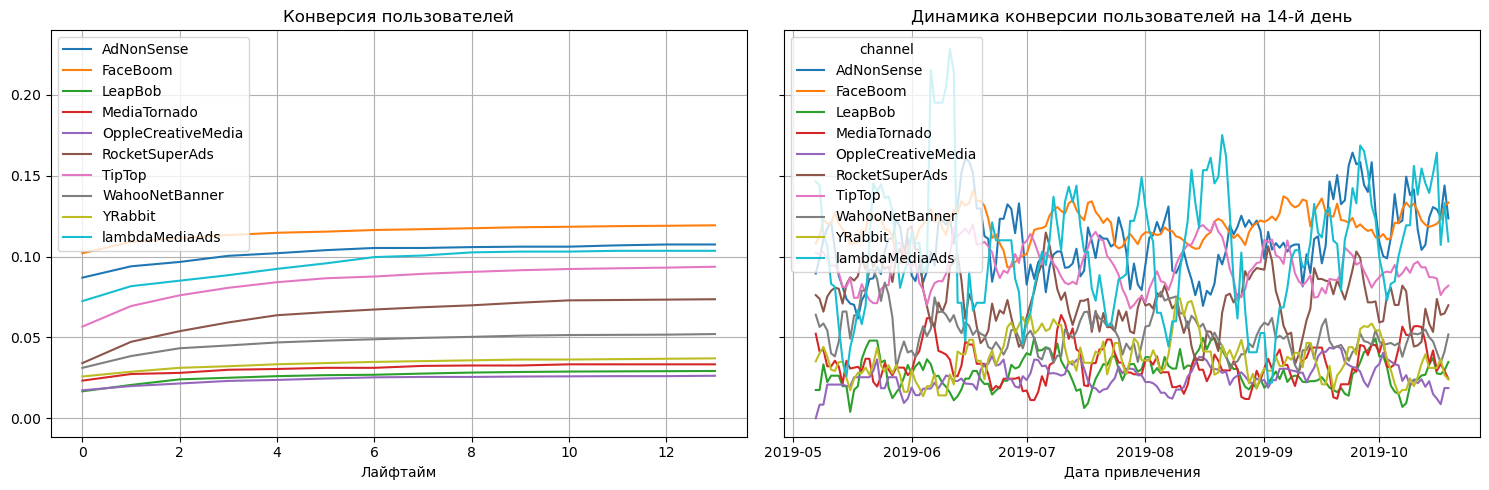

In [42]:
# посмотрим конверсию по источникам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

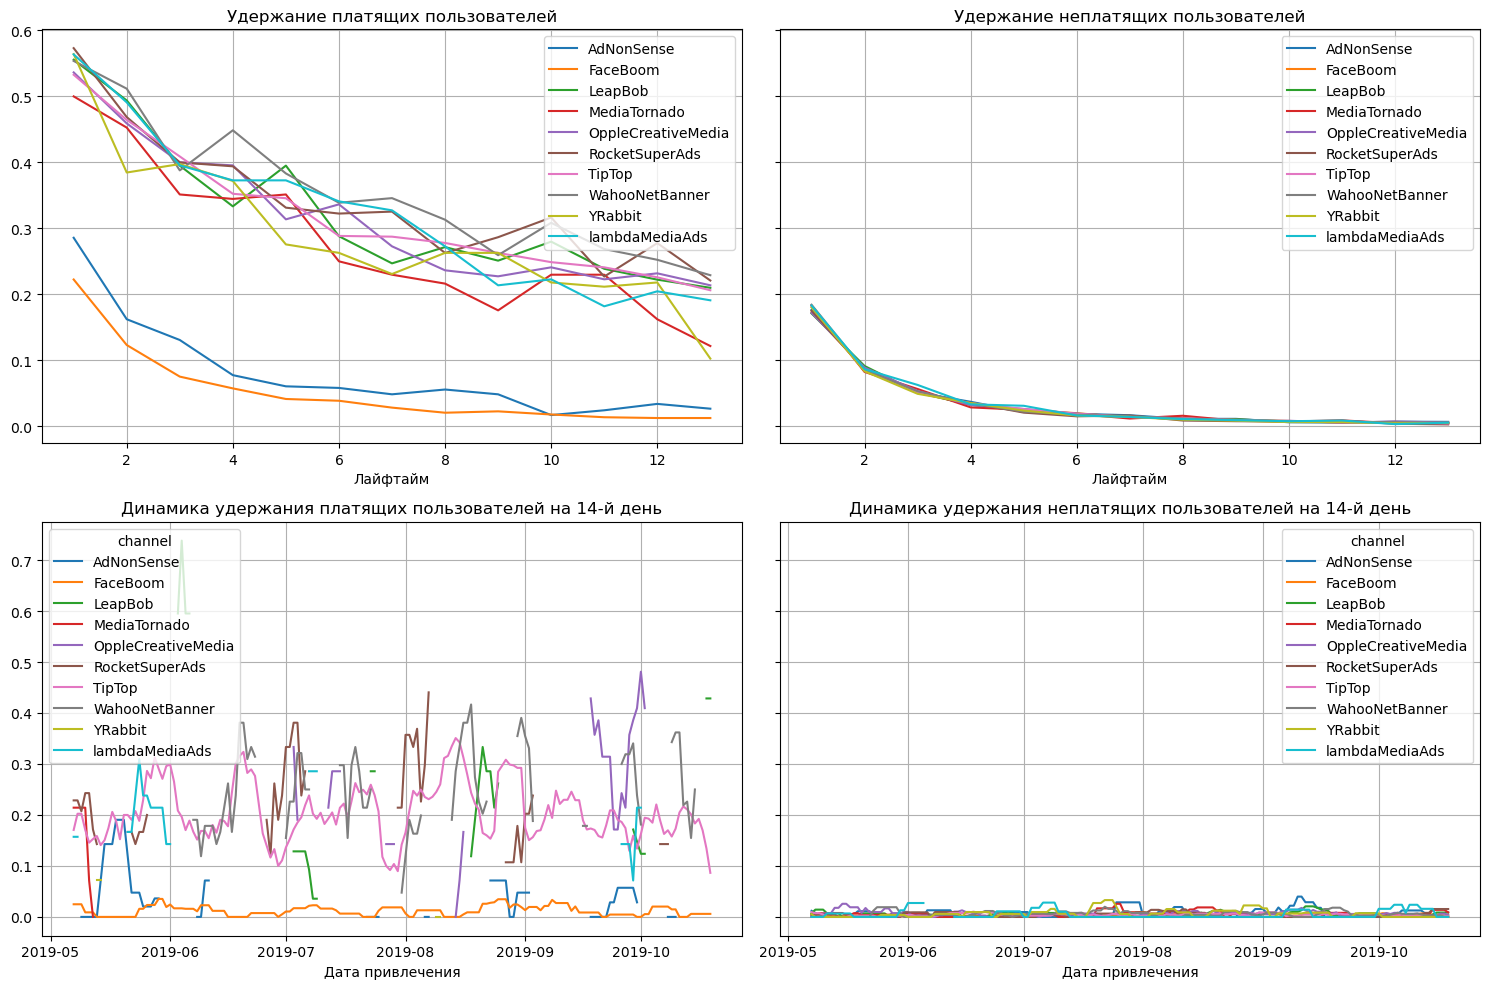

In [43]:
# посмотрим удержание пользователей по источникам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы по каналам привлечения**:
- стоимость привлечения пользователей по TipTop значительно превышает уровень других каналов рекламы
- на 14й день не окупаются только три источника трафика: TipTop, FaceBoom, AdNonSence (эти же каналы имеют наибольшие показатели по проценту платящих пользователей). 
- на перспективу стоит отметить канал lambdaMediaAds, по которому высокий LTV, а также относительно быстрый уровень окупаемости
- значительные проблемы с удержанием платящих пользователей замечены у каналов FaceBoom и AdNonSence - данные каналы имеют высокую конверсию, при этом самые низкие показатели удержания

#### Анализ пользователей из США 

В связи с тем, что в США представлено наибольшее количество пользователей и именно из-за данной страны все показатели идут вниз, посмотрим на устройства и каналы привлечения для данной страны.



In [44]:
#отберем пользователей из США
profiles_usa = profiles.query('region == "United States"')

#сгруппируем по устройствам
profiles_usa.groupby('device').agg({'user_id':'nunique'})

user_id
device          
Android    12436
Mac        15424
PC          6421
iPhone     27548

Всего пользователей 150 тыс., из них 100 тыс. приходится на США. Практически половина пользователей США используют IPhone. Возможно проблемы при отсутствии окупаемости как раз зависят от того, что источники рекламы, которые не окупаются (TipTop, FaceBoom, AdNonSence) как раз работают на пользователей с продукцией Apple.


In [45]:
profiles_usa.query('channel in ["TipTop","FaceBoom", "AdNonSence"]').groupby('device').agg({'user_id':'nunique'})

user_id
device          
Android     9764
Mac        12085
PC          5020
iPhone     21836

Теория, что данные источники относятся только к продукции Apple не подтвердилась, однако, стало понятно, что более половины всех пользователей из США привлечено благодаря данным каналам. 

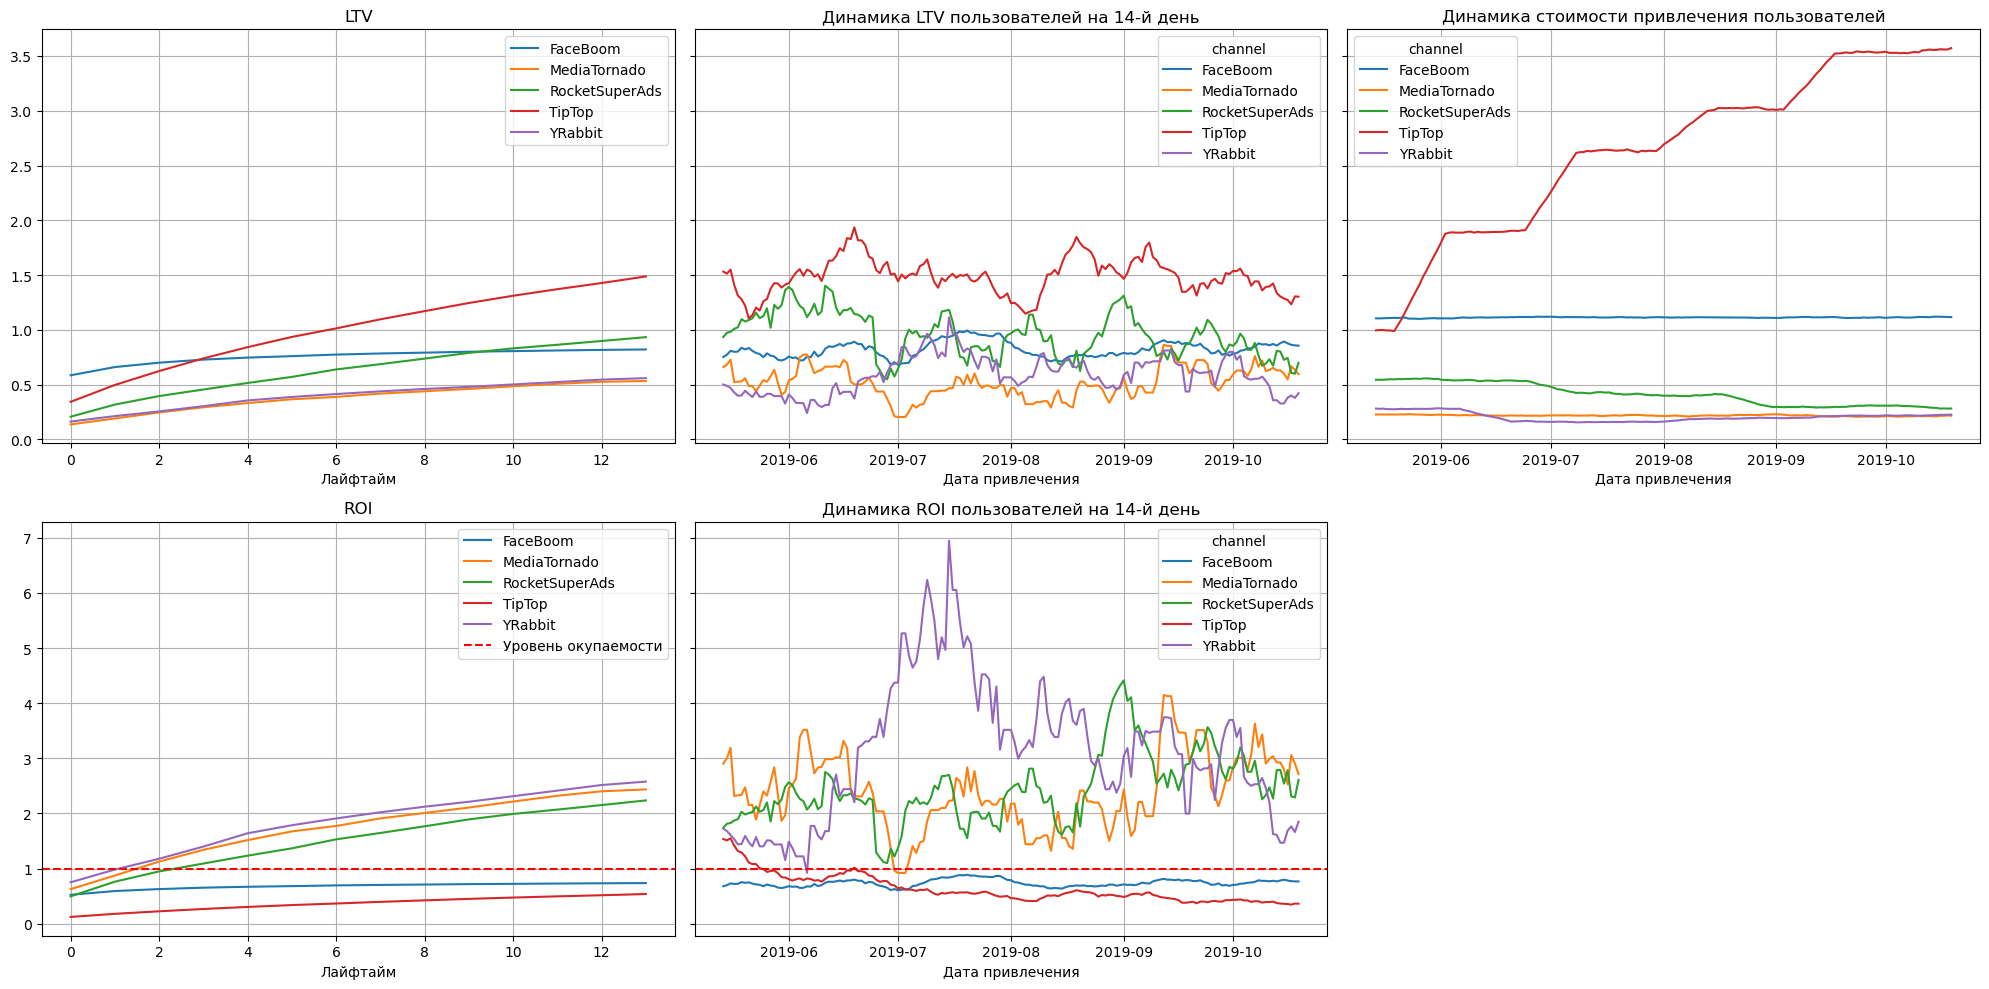

In [46]:
# считаем LTV и ROI по каналам для США, строим графики
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Интересно, что в США не окупаются только два источника - TipTop и FaceBoom, которые имеют наибольшие рекламные бюджеты во всей компании. AdNonSence вообще не представлен в США, хотя исходя из общих графиков также является неокупаемым. Интересно, что стоимость привлечения по FaceBoom оставалась неизменной на протяжении всего времени, а стоимость привлечения пользователей посредством TipTop значительно увеличивались с каждым месяцем. 

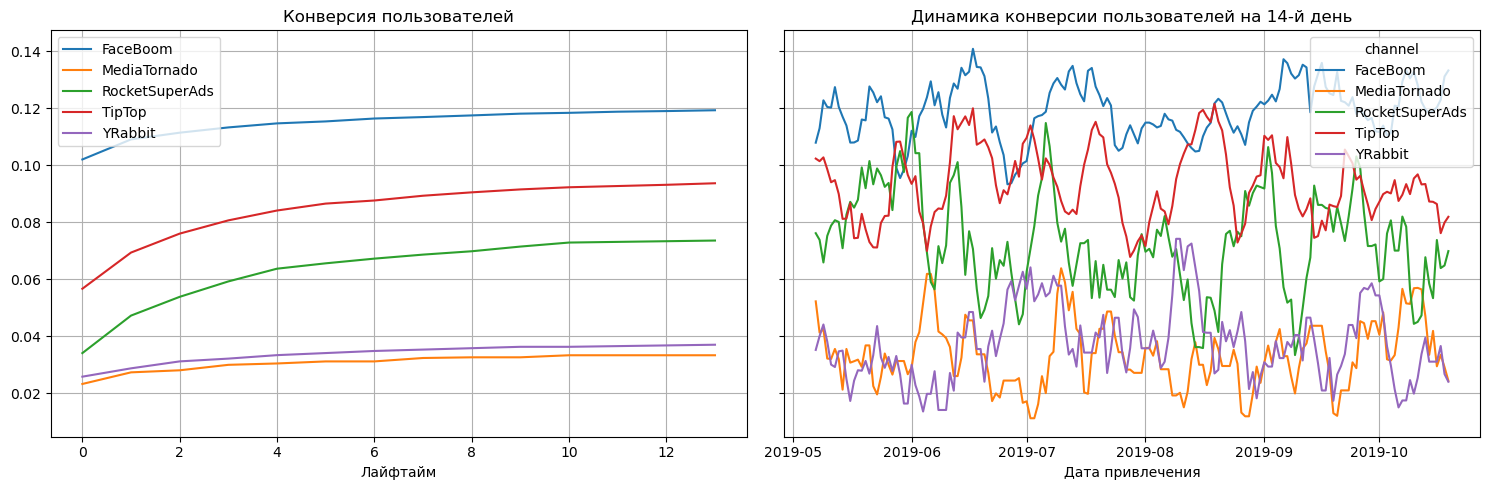

In [47]:
# посмотрим конверсию по источникам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)



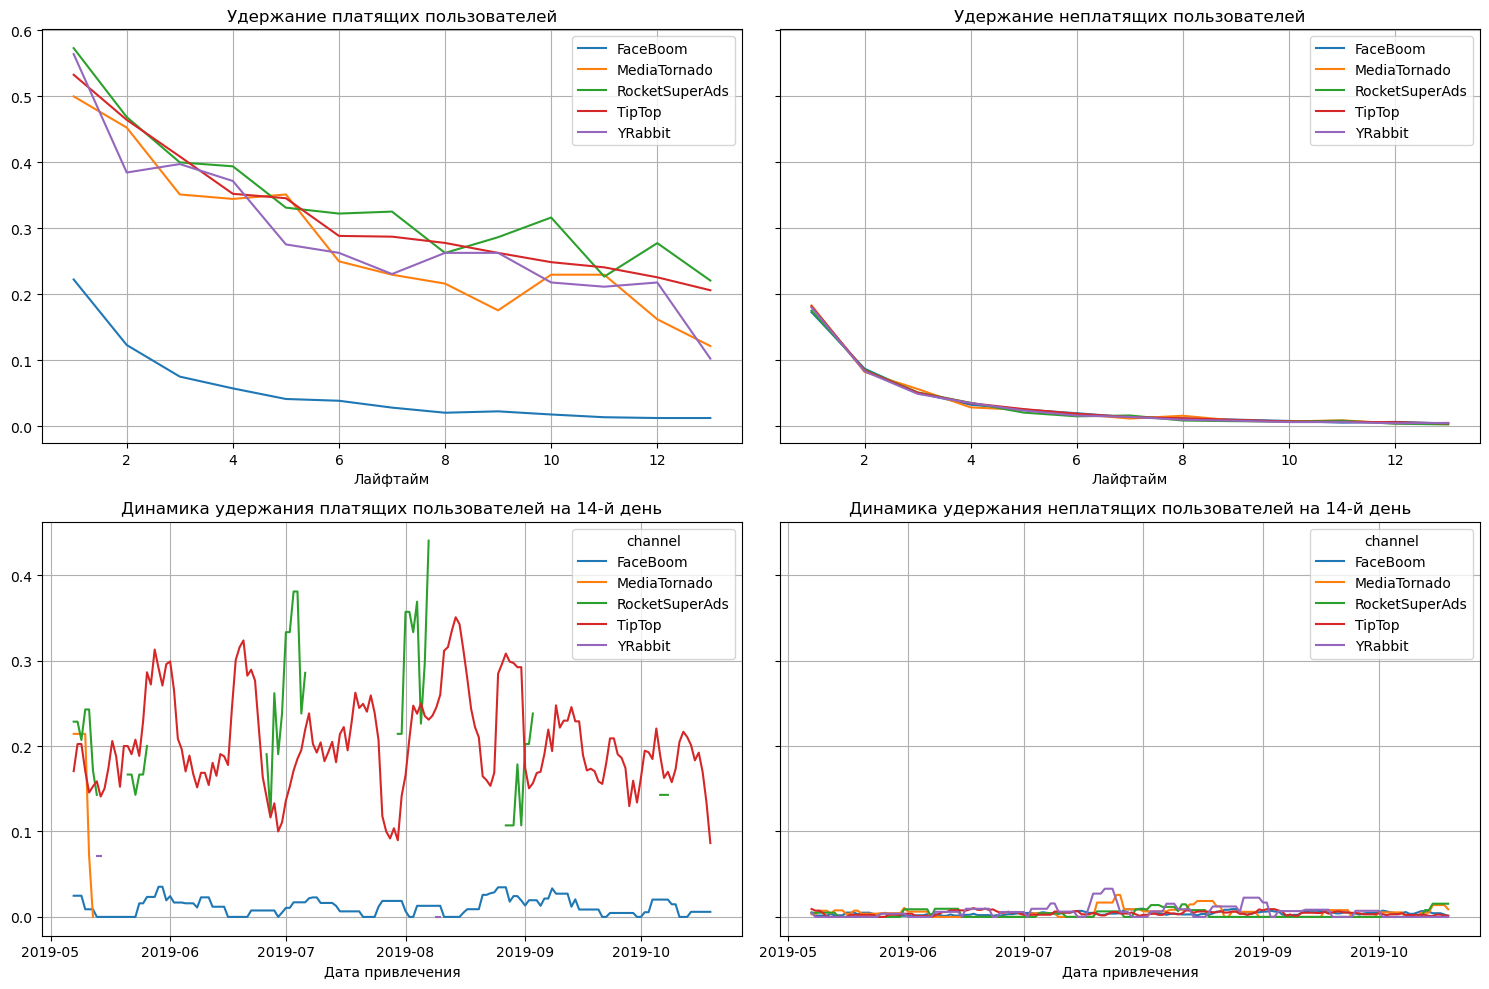

In [48]:
# посмотрим удержание пользователей по источникам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

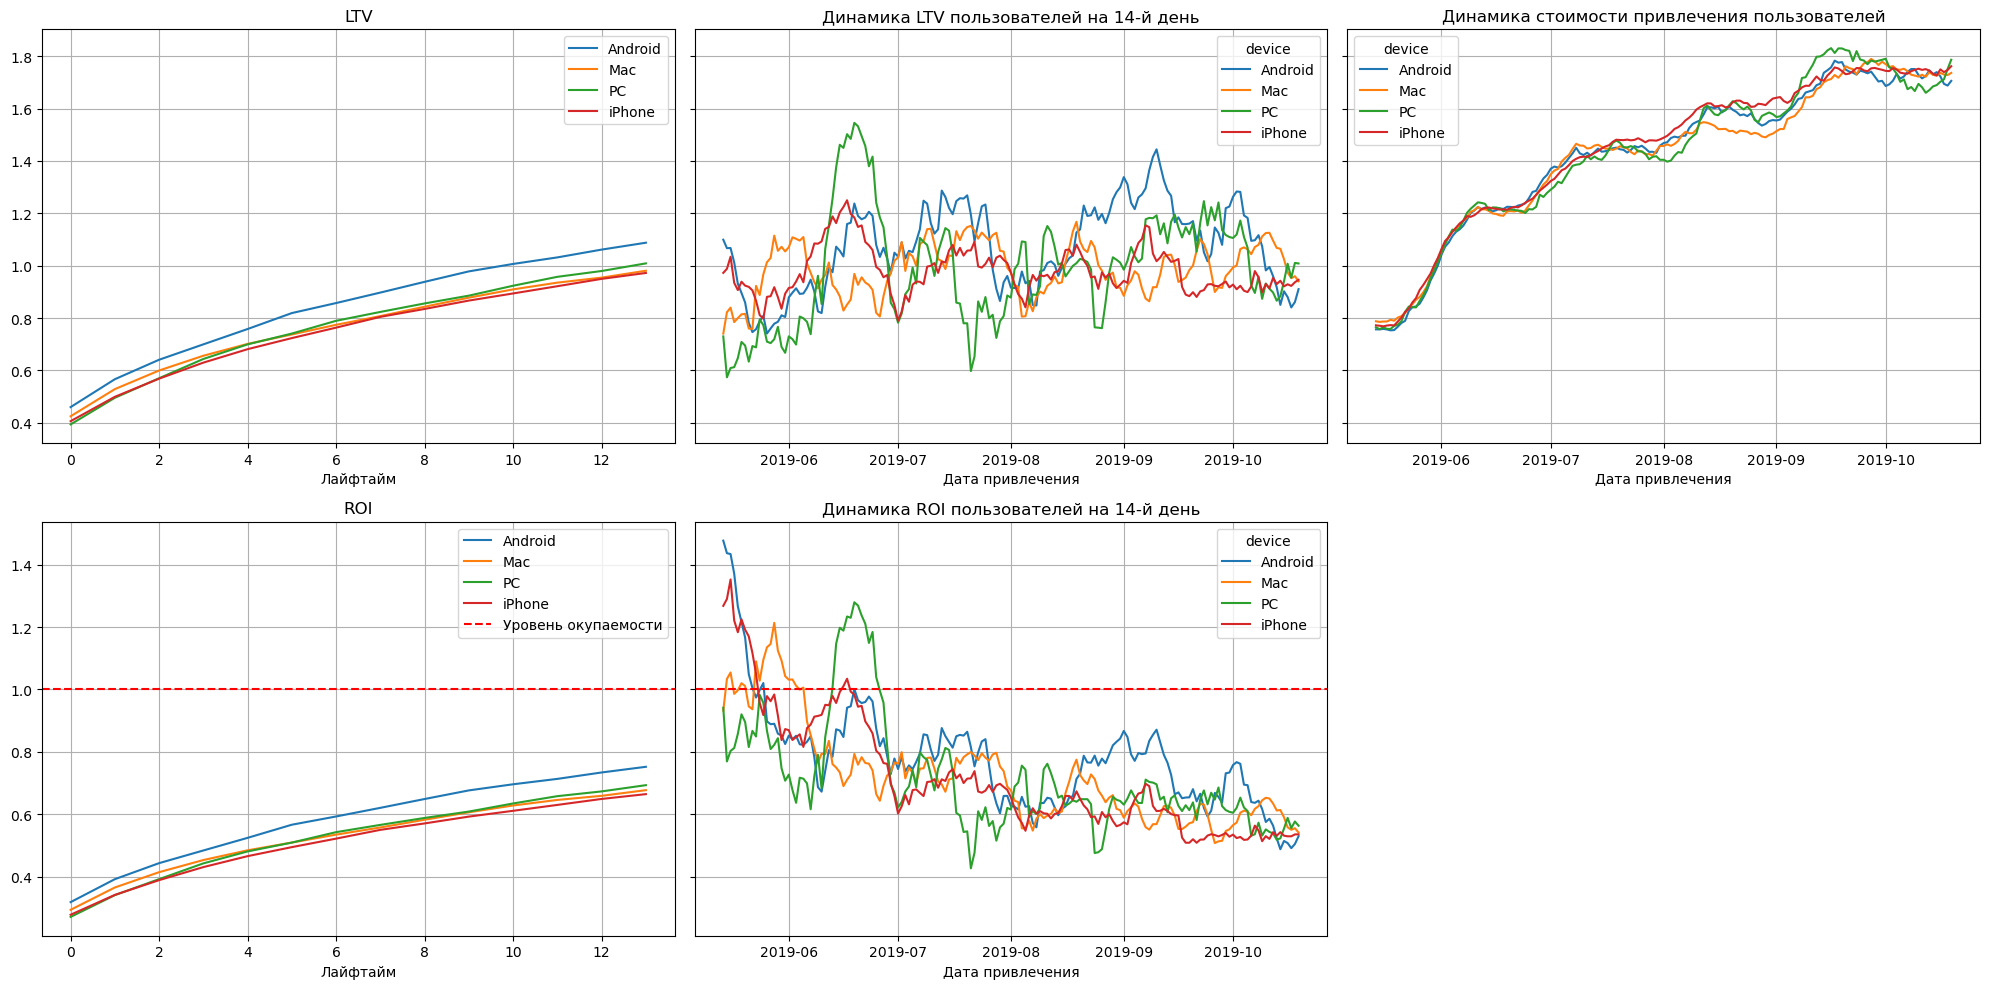

In [49]:
# считаем LTV и ROI по устройствам для США, строим графики
dimensions = ['device']
    
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

В связи с тем, что данные убыточные каналы привлечения работают на всех устройствах - график ROI по всем устройствам в США также не достигает уровня окупаемости. Следовательно, можно сделать вывод, что влияние на текущее положение дел оказывают не конкретные устройства, а именно каналы привлечения. Проблемы в США замечены по каналу FaceBoom и TipTop - оба этих канала не окупаются. FaceBoom по причине низкого удержания пользователей, TipTop по причине высокой стоимости привлечения пользователей и также относительно низких показателей удержания. Самые перспективные источники рекламы для данного региона - MediaTornado, RocketSuperAds, YRabbit (данные источники окупаются, имеют низкую стоимость привлечения новых пользователей, а также высокие показатели удержания). Особенное внимание стоит обратить на RocketSuperAds с одними из самых больших показателей конверсии. 

#### Анализ пользователей из Европы

В связи с тем, что на Европейские страны приходится всего 30% рынка в совокупности, то для целей анализа пользователи также будут рассматриваться вместе. При этом, как было выяснено ранее, проблемы маркетинга исходят скорее от источников трафика, чем от конкретных устройств. Следовательно, сосредоточимся на анализе источников привлечения пользователей. 

In [50]:
#отберем пользователей из Европы
profiles_eu = profiles.query('region != "United States"')

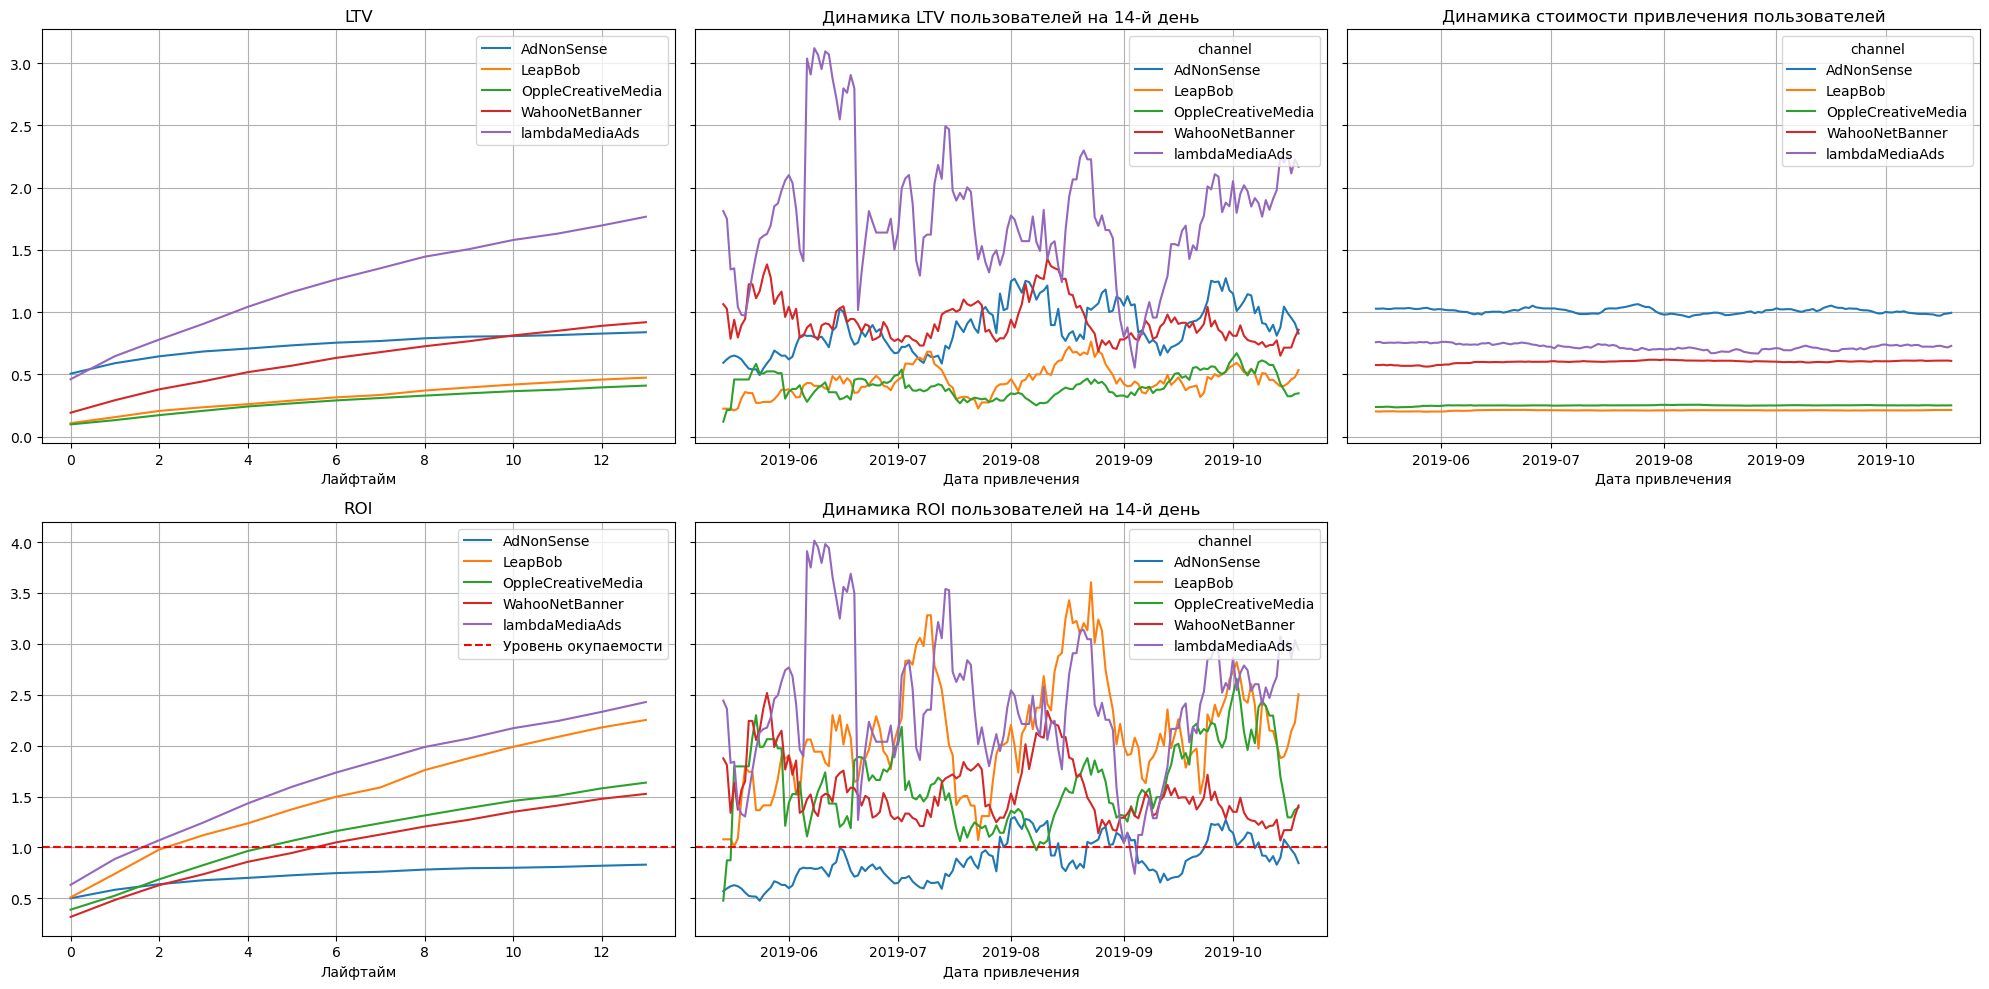

In [51]:
# считаем LTV и ROI по каналам для Европы, строим графики
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

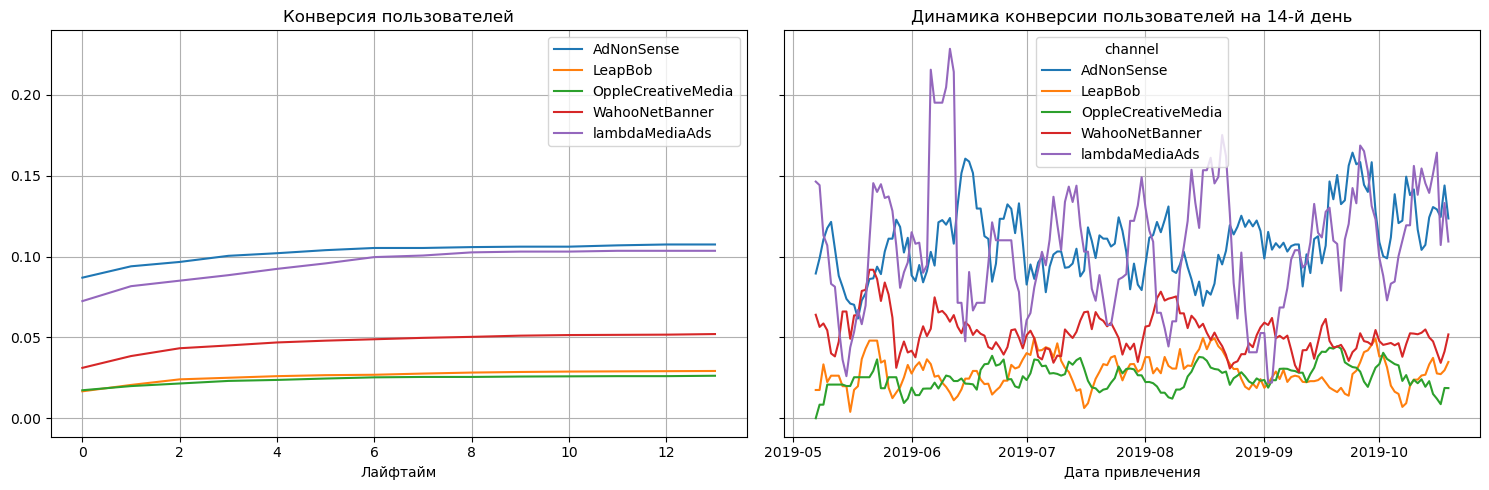

In [52]:
# посмотрим конверсию по источникам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_eu, orders, observation_date, horizon_days, dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)


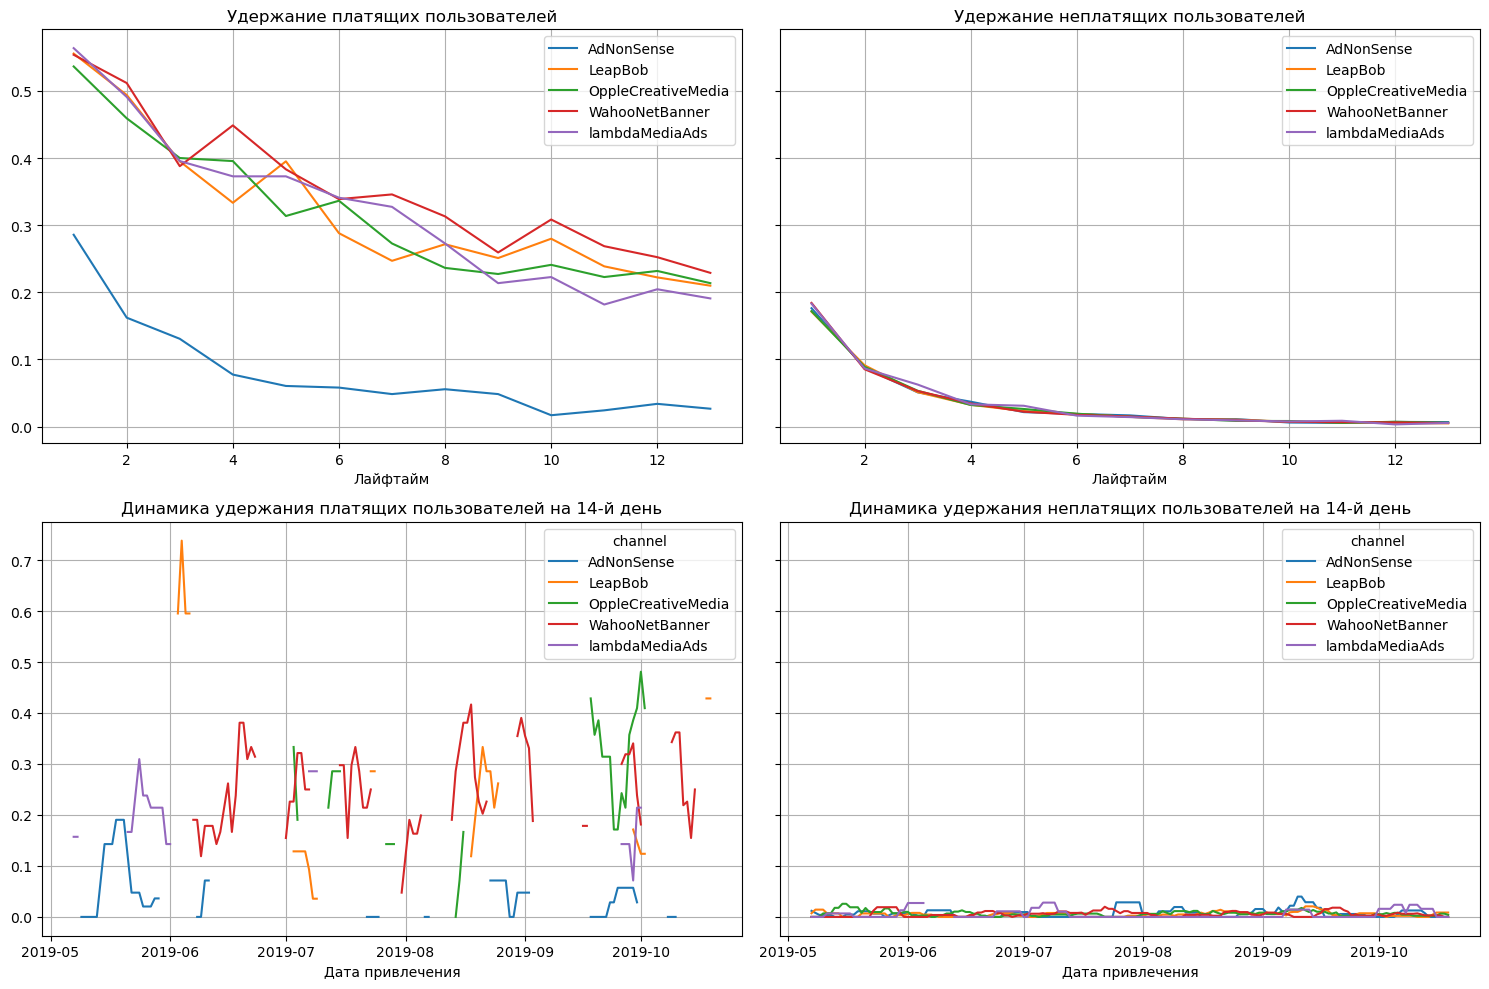

In [53]:
# посмотрим удержание пользователей по источникам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_eu, visits, observation_date, horizon_days, dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы по Европе:**
- единственный канал, который не окупается в Европе - это AdNonSense
- рекомендуется рассмотреть как альтернативу канал lambdaMediaAds, который также имеет высокую конверсию, при этом окупается практически на 1-2 день, а также имеет гораздо более лучшие показатели удержания пользователей и LTV
- также неплохой альтернативой может являться канал WahooNetBanner с очень высоким показателем удержания платящих пользователей, при этом окупающийся на 6 день использования приложения

### Общие выводы

#### Проделанный анализ
- проведена обработка данных: изменены типы данных, проведена проверка на наличие дубликатов и пропусков
- определены профили уникальных пользователей
- пользователи проанализированы по странам, устройствам, рекламным источникам в целом
- проанализированы расходы на рекламу: общие затраты за отчетный период, разбивка по источникам рекламы, процент платящих пользователей по каждому источнику трафика, средние расходы на одного пользователя по каналу привлечения
- проведена оценка окупаемости рекламы (LTV, ROI, CAC): в общем, по странам, по устройствам, по каналам привлечения
- дополнительно проведен анализ пользователей из США в связи с их преобладанием в общем числе пользователей
- сформулированы выводы и рекомендации

#### Выводы и рекомендации по результатам анализа

- в данных отсутствуют пропуски, дубликаты, что может свидетельствовать об их хорошем качестве
- данные представлены за период с 1 мая по 27 октября 2019 года
- общее количество уникальных пользователей 150 008 чел.
- больше всего пользователей из США - более 100 тыс. (в 5 раз больше остальных стран), также у данной страны наблюдается наиболее высокий процент платящих пользователей 6,9%. В то время как у остальных стран и количество пользователей и процент платящих пользователей примерно одинаковый (4%).
- наибольшее количество пользователей предпочитают продукцию компании Apple: всего 84 521 человек. Также среди данных пользователей наибольший процент платящих пользователей более 6,2% в зависимости от устройства. Лидером же по устройствам в целом по количеству пользователей является IPhone (54 тыс.). 
- наибольшее количество пользователей привлечено с помощью органического трафика. При этом, доля плательщиков среди них самая низкая 2.05%.
- наиболее интересным FaceBoom - при том, что количество пользователей, привлеченных по данному каналу практически в два раза меньше, чем от органического трафика, количество плательщиков же в натуральном выражении в два раза больше - 3,5 тыс. человек. Процент платящих пользователей составляет 12,20%, что является наиболее высоким показателям по всем источникам. Также каналы с высокими показателями процентов плательщиков пользователей (9-11%) - TipTop, AdNonSense, lambdaMediaAds.
- наиболее неэффективными каналами (процент платящих пользователей ниже 4%) можно назвать: OppleCreativeMedia, LeapBob, MediaTornado, YRabbit.
- Общий рекламный бюджет составил 105 497. Наибольшая доля бюджета (более 50%) приходится на источник TipTop (51,9 тыс.) Также более 30% относится к источнику FaceBoom (затраты 32 тыс.).
- рекламный бюджет TipTop значительно превышает остальные затраты и начиная с 38 недели увеличился более чем на 730 (или на 30%). Средняя стоимость за одного пользователя у данного канала 2,8. При этом процент платящих пользователей из данного источника не самый высокий. Источники, имеющие бОльший процент платящих пользователей при этом более чем в два раза дешевле FaceBoom - 1,11 и AdNonSense - 1.
- на 14й день общий ROI ниже уровня окупаемости
- LTV по всем устройствам (за исключением РС) является примерно одинаковым
- стоимость привлечения пользователей на устройствах компании Apple (MAC и IPhone) начиная с июня значительно выше стоимости по другим устройствам, по всем устройствам (кроме РС) не достигается уровень окупаемости
- основное влияние на неокупаемость в США оказывают именно каналы привлечения, а не конкретные устройства. 

**Рекомендации для отдела маркетинга:**
Типичный пользователь приложения скорее всего будет из США и использует продукцию компании Apple (MAC и IPhone), следовательно основной упор в маркетинговой политике необходимо делать именно на данный регион и устройства.
1. **По США:**
- именно данный регион является причиной неокупаемости маркетинговых кампаний в 14-дневный период
- основные проблемы зафиксированы в каналах привлечения TipTop (высокий уровень САС), а также FaceBoom (низкие показатели удержания платящих клиентов). Так как в совокупности на данные каналы приходится более 80% всего рекламного бюджета - рекомендуется диверсифицировать источники привлечения пользователей и рассмотреть возможность перехода на более эффективные каналы. 
- самые перспективные источники рекламы для данного региона - MediaTornado, RocketSuperAds, YRabbit (данные источники окупаются, имеют низкую стоимость привлечения новых пользователей, а также высокие показатели удержания). Особенное внимание стоит обратить на RocketSuperAds с одними из самых больших показателей конверсии.

2. **По Европе:**
- общие показатели по данному региону значительно лучше, чем по США, но один источник не окупается в связи с высокой стоимостью привлечения пользователей AdNonSense 
- рекомендуется рассмотреть как альтернативу канал lambdaMediaAds, который также имеет высокую конверсию, при этом окупается практически на 1-2 день, а также имеет гораздо более лучшие показатели удержания пользователей и LTV
- также неплохой альтернативой может являться канал WahooNetBanner с очень высоким показателем удержания платящих пользователей, при этом окупающийся на 6 день использования приложения 

